# Predicting Prices of Used Cars on Craigslist

## Intro

### Context
Buyer’s Choice (BC) is a smalled used car company based in CT lead by CEO Dapper Dan. BC's usual process for deciding to buy vehicles from the warehouse is to determine what the likely price would be if the vehicle was sold in the store (BC Price). If the BC Price is over $5k greater than the warehouse price they buy the vehicle. 

However with the advent of Covid people just are not coming into the store. So they have switched to selling their cars online. These prices often differ from the prices they would normally get at the store.

The company was recently been given the option to buy 30 of the 2018 Tesla Model 3’s at $ 30K. They want to know if they should take the deal. 

### Problem statement 
Should used car dealership Buyer’s Choice buy 30 gently used 2018 Tesla 3 at the price of \\$ 30K? To answer this question we need to predict the price of selling a 2018 Tesla 3 online. If it is above $ 30K we should buy the vehices. 


### Data

To determine online prices we look at the price of used vehicles on Craigslist. The dataset we used was created by Austin Reese January 2020 from scraping data from  "every used vehicle entry within the United States" on Craigslist on Feb 2020. Besides price this data includes other this listed on the used vehicle entry like mileage, the model and condition of the vehicle. Link: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

Four other supplementary databases were used:

1) For vehicle model data we used data from from back4app an open data source that uses categories vehicle models based on US department of transportation. These categories are grouping such as "convertible" or "pickup".
Website: https://www.back4app.com/database/back4app/car-make-model-dataset

2) We also tried to find vehicle MSRP (aka price the market price listed by companies when the vehicle was new). We used data scraped from Edmunds (One of the most well known reviews of automobiles and their prices in the USA). This data was scraped, compiled and put on kaggle by CopperUnion in 2016 "https://www.kaggle.com/CooperUnion/cardataset"

3) State Gas prices  come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date available from the scraping of the Craiglist data which was Feb 22 https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/


4) This data for household income by state was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is recommend by the WSJ and the NYT.

## Prepping the Data

Loading Software

In [3]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.preprocessing import MinMaxScaler, StandardScaler



Loading Data

In [184]:
#Get Path
import os
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames

file = 'vehicles.csv'

print('If you are using the data in my github the data is actually already at the auto_data.csv stage renamed')
print('However all the code can be run except for one cell which is clearly marked')

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)



#Open data
auto_data.head(5)

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto trimmed price.ipynb', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'auto_clean_copy2-Copy1.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2_sqrt.ipynb', 'auto_clean_copy3 State vs Region.ipynb', 'auto_clean_copy3- expand tuning-Copy1.ipynb', 'auto_clean_copy3- expand tuning.ipynb', 'auto_clean_p1_cleandata.ipynb', 'auto_clean_p2_mergedata.ipynb', 'auto_clean_p3_impute_data.ipynb', 'auto_clean_p4_EDA.ipynb', 'CapstoneProjectSlides_example.pdf', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Feature Importance.png', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_d

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7088746062,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,10299,2012.000,acura,tl,NaN,NaN,...,NaN,NaN,other,blue,https://images.craigslist.org/01414_3LIXs9EO33...,2012 Acura TL Base 4dr Sedan Offered by: B...,nan,nc,35.764,-78.744
1,7088745301,https://greensboro.craigslist.org/ctd/d/bmw-3-...,greensboro,https://greensboro.craigslist.org,0,2011.000,bmw,335,NaN,6 cylinders,...,rwd,NaN,convertible,blue,https://images.craigslist.org/00S0S_1kTatLGLxB...,BMW 3 Series 335i Convertible Navigation Dakot...,nan,nc,nan,nan
2,7088744126,https://greensboro.craigslist.org/cto/d/greens...,greensboro,https://greensboro.craigslist.org,9500,2011.000,jaguar,xf,excellent,NaN,...,NaN,NaN,NaN,blue,https://images.craigslist.org/00505_f22HGItCRp...,2011 jaguar XF premium - estate sale. Retired ...,nan,nc,36.103,-79.879
3,7088743681,https://greensboro.craigslist.org/ctd/d/cary-2...,greensboro,https://greensboro.craigslist.org,3995,2004.000,honda,element,NaN,NaN,...,fwd,NaN,SUV,orange,https://images.craigslist.org/00E0E_eAUnhFF86M...,2004 Honda Element LX 4dr SUV Offered by: ...,nan,nc,35.764,-78.744
4,7074612539,https://lincoln.craigslist.org/ctd/d/gretna-20...,lincoln,https://lincoln.craigslist.org,41988,2016.000,chevrolet,silverado k2500hd,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.craigslist.org/00S0S_8msT7RQquO...,"Shop Indoors, Heated Showroom!!!www.gretnaauto...",nan,ne,41.135,-96.246


Exploratory Data1

In [185]:
#Print the columns names of the entire dataframe
print(auto_data.columns)
# Review the column names, null value counts and data types of your data frame.
auto_data.info()


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 


Variables drop
* url   - We will not be using urls in this study
* region_url   -  We will not be using urls in this study
* description   - Unique for each vehicle
* VIN   - Unique for each vehicle
* image_url - We will not be using urls in this study 
* county    - there is no non 0 data points there

Drop if data is missing price since we don't know the price we cannot use the vehicle to help build our model to predict price.

Drop if data is model, model year, mileage and condition.
* Common wisdom suggests that the model, age, mileage and condition (war) are the usual contributors to vehicle price.
* While this study will look at other variables we will keep these as the minimum variables.


In [186]:
auto_data= auto_data.drop(columns=['url', 'region_url', 'image_url', 'county', 'description', 'vin'])
print(auto_data.columns)
auto_data= auto_data.dropna(subset=['condition', 'year', 'odometer', 'model', 'price'])

#known main points for an auto sale condition, age, mileage, type of car if the cars don't have it we don't want it

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long'],
      dtype='object')


### Transforming Strings: Cleaning 

* Cylinders come in whole numbers for an engine (there is no quarter cylinder) so these strings can be converted to integers.
* The manufacturer and model regardless of spacing and capitalization aka cars labeled as "BMW" or "bmw" or "BMW   " are all manufactured by BMW.

### Cleaning Rules: Common Sense

We want to use data that will help us predict the price of a good condition vehicle. Therefore we are not looking at million dollar superluxury cars nor are we looking at vehicle that are being sold for scraps or as junkers.

* This study is not looking at Super luxury cars/ antique cars: 
    * None of the vehicles should have a price greater than half a million
    * They should not be from a Super Luxury Brand (Aston Martin, Ferrari)
* This study is not looking at motorbikes or busses 
    * We don't need Harley Davidson’s or Hennessey’s 
* This study is not looking at junker cars so we do not need vehicles:
    * Priced at 1000 dollars or less
    * That have over a half million miles on them
    * In poor condition or have a title status equal or worse than salvage
    * Are over than 10 years old (we are also not looking at antique cars)
* Cleaning obvious errors:
    * We are looking at used vehicles so the vehicles age should be greater than 1 year

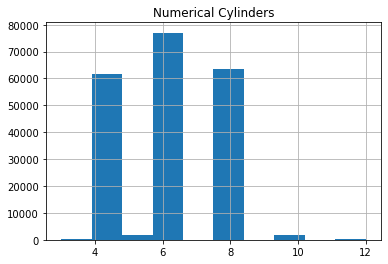

In [187]:
#Turn Cylinder column from string to numeric
auto_data['cyl'] = auto_data['cylinders']
auto_data['cyl'] = auto_data['cyl'].replace('other', np.nan)
auto_data['cyl'] = auto_data['cyl'].astype(str).str[0:2]
auto_data['cyl'] = auto_data['cyl'].str.strip()
auto_data['cyl'] = auto_data['cyl'].replace('na', np.nan)
auto_data['cyl'] = pd.to_numeric(auto_data['cyl'])
auto_data['cylinders']= auto_data['cyl']
auto_data= auto_data.drop(['cyl'], axis=1)

#plot Cylinders
plt.title("Numerical Cylinders")
hist = auto_data.cylinders.hist(bins=10)

In [188]:
#Neaten Strings
#Fix manufacturer
auto_data['manufacturer']= auto_data['manufacturer'].str.title().str.strip()
auto_data['manufacturer']= auto_data['manufacturer'].str.replace(' ', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Land-Rover', 'Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Rover', 'Land-Rover') 
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('Porche', 'Porsche')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('---', '-')
auto_data['manufacturer']= auto_data['manufacturer'].str.replace('--', '-')


#Fix model
auto_data['model']= auto_data['model'].str.title().str.strip()
auto_data['model']= auto_data['model'].str.replace(' ', '-')
auto_data['model']= auto_data['model'].str.replace('---', '-')
auto_data['model']= auto_data['model'].str.replace('--', '-')

#fix Type
auto_data['type']= auto_data['type'].str.title().str.strip()

#States are state codes
auto_data['state'] = auto_data['state'].str.upper().str.strip()

#If no paint color is given its unlisted and its unrealistc to try to impute it
auto_data['paint_color'] = auto_data['paint_color'].fillna('unlisted')


In [189]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261705 entries, 2 to 539752
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            261705 non-null  int64  
 1   region        261705 non-null  object 
 2   price         261705 non-null  int64  
 3   year          261705 non-null  float64
 4   manufacturer  252526 non-null  object 
 5   model         261705 non-null  object 
 6   condition     261705 non-null  object 
 7   cylinders     206443 non-null  float64
 8   fuel          261683 non-null  object 
 9   odometer      261705 non-null  float64
 10  title_status  261699 non-null  object 
 11  transmission  261515 non-null  object 
 12  drive         221851 non-null  object 
 13  size          124791 non-null  object 
 14  type          226891 non-null  object 
 15  paint_color   261705 non-null  object 
 16  state         261705 non-null  object 
 17  lat           259496 non-null  float64
 18  long

In [190]:
# If we are dealing with a vehicle with over a half milion miles we have more problem
auto_data = auto_data[(auto_data.odometer< 500000)] 


#This study is not look at eather junkers or antiques so 
#a: age has to be greater than 0 and less than 11 years
#b: price has to be greater than $100 and less than half million
#c: mileage has to be greater than or equal to 0 and less than half million

auto_data['age'] = 2020-auto_data['year']
auto_data = auto_data[(auto_data.age > 0) & (auto_data.age <= 10)]
auto_data = auto_data[(auto_data.price >= 100) & (auto_data.price <= 500000)]
auto_data = auto_data[(auto_data.odometer >= 0) & (auto_data.odometer <= 500000)]


print(f"Maximum price: $ {auto_data.price.max()} \nMinimum price: $ {auto_data.price.min()} ")
print(f"Maximum age:  {auto_data.age.max()} years \nMinimum age: {auto_data.age.min()} years ")
print(f"Maximum mileage: {auto_data.odometer.max()} \nMinimum mileage: {auto_data.odometer.min()} ")


Maximum price: $ 479000 
Minimum price: $ 100 
Maximum age:  10.0 years 
Minimum age: 1.0 years 
Maximum mileage: 499103.0 
Minimum mileage: 0.0 


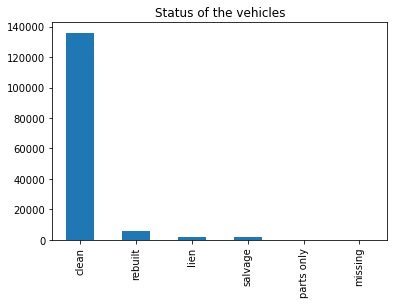

In [191]:
#This study is not look junkers so condition and title_ status is better than salvage

#See Status of Vehicles
auto_data.title_status.value_counts().plot.bar()
plt.title("Status of the vehicles")
plt.show()


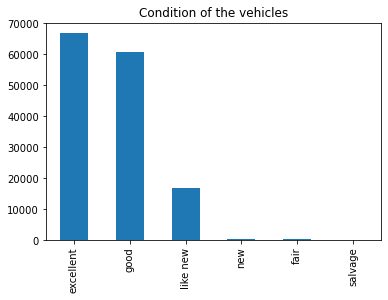

In [192]:
#See Condition of Vehicles

auto_data.condition.value_counts().plot.bar()
plt.title("Condition of the vehicles")
plt.show()

In [193]:
#This study does not look junkers so condition and title_ status is better than salvage

idx1 = auto_data[auto_data["condition"] == "salvage"].index

for w in ["salvage","lien","missing","parts only", 'rebuilt']:
    idx2 = auto_data[auto_data["title_status"] == w].index
    idx1 = idx1.union(idx2)
    
auto_data.drop(idx1, axis = 0, inplace = True)

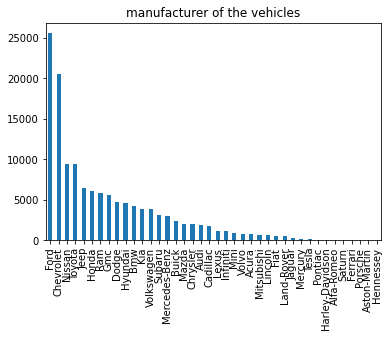

In [194]:
#We are not looking at motorbikes

#Graph manufacturers

auto_data.manufacturer.value_counts().plot.bar()
plt.title("manufacturer of the vehicles")
plt.show()

In [195]:

#We are not looking at motorbikes
auto_data = auto_data[auto_data.manufacturer != 'Harley-Davidson']
auto_data = auto_data[auto_data.manufacturer != 'Hennessey']



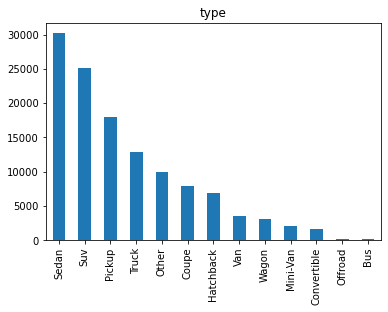

In [196]:
#We are not looking at buses
#Graph type

auto_data.type.value_counts().plot.bar()
plt.title("type")
plt.show()

In [197]:
#We are not looking at bus
auto_data = auto_data[auto_data.type != 'bus']


In [198]:
#Create Make Model Model Year Key (Useful for later)
auto_data['mmy_a']=auto_data['manufacturer']+' '+auto_data['model']+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a']=auto_data['mmy_a'].str.title()

auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model'].str.split(' ').str[0]+ ' '+ auto_data['year'].astype(int).astype(str)
auto_data['mmy_a2']=auto_data['mmy_a2'].str.title()


In [199]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 2 to 539744
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135864 non-null  int64  
 1   region        135864 non-null  object 
 2   price         135864 non-null  int64  
 3   year          135864 non-null  float64
 4   manufacturer  133027 non-null  object 
 5   model         135864 non-null  object 
 6   condition     135864 non-null  object 
 7   cylinders     97736 non-null   float64
 8   fuel          135861 non-null  object 
 9   odometer      135864 non-null  float64
 10  title_status  135858 non-null  object 
 11  transmission  135734 non-null  object 
 12  drive         112965 non-null  object 
 13  size          53221 non-null   object 
 14  type          121915 non-null  object 
 15  paint_color   135864 non-null  object 
 16  state         135864 non-null  object 
 17  lat           134746 non-null  float64
 18  long

In [200]:
auto_data.describe()

,id,price,year,cylinders,odometer,lat,long,age
count,135864.000,135864.000,135864.000,97736.000,135864.000,134746.000,134746.000,135864.000
mean,7087761305.522,16985.194,2014.186,5.875,78798.992,37.930,-90.852,5.814
std,5017708.268,10949.605,2.571,1.592,50567.453,5.354,15.905,2.571
min,7065764796.000,100.000,2010.000,3.000,0.000,-51.393,-166.377,1.000
25%,7085130229.500,9900.000,2012.000,4.000,37704.000,33.786,-96.881,4.000
50%,7088878285.500,15200.000,2014.000,6.000,73298.000,38.360,-84.510,6.000
75%,7091975796.250,21900.000,2016.000,8.000,111700.750,42.064,-80.254,8.000
max,7093535816.000,450000.000,2019.000,12.000,499103.000,84.515,94.125,10.000


Save Data

In [201]:
sub_file = 'data'
new_file = 'auto_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data.to_csv(new_file_name_path, index=False)

## Categorical Data
We want data on what segment the vehicle is in as that might change the prices significantly.
We got this data from back4app an open data source that uses categories based on US department of transportation.

Website: https://www.back4app.com/database/back4app/car-make-model-dataset

In [202]:
#Get Categorical Data

where = urllib.parse.quote_plus("""
{
    "Category": {
        "$exists": true
    },
    "Year": {
        "$gte": 2010
    }
}
""")
url = 'https://parseapi.back4app.com/classes/Carmodels_Car_Model_List?limit=5000&where=%s' % where
headers = {
    'X-Parse-Application-Id': 'pozCwVISt2yfzi2wJjwo0JiMIJclsUAOchP4AuJO', # This is your app's application id
    'X-Parse-REST-API-Key': 'Jtc8r91VIJOizG8ReKkaseZcugQjAx4vG1WKbJye' # This is your app's REST API key
}
data_json = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need


#import collections

In [203]:
#the above data was too nested a dictionaries listed in a list that was in a list that was a dictionary
print(type(data_json))
list_values = [ v for v in data_json.values() ] #undoes dictionary

list_value_items = [y for x in list_values for y in x] # undoes list

cat_data = pd.DataFrame.from_dict(list_value_items) #turns list of dictionaries into data frame


<class 'dict'>


In [204]:
#we don't need object id or created at
cat_data= cat_data.drop(['objectId', 'createdAt'], axis=1)
print(cat_data.head())
cat_data.describe()

   Year       Make         Model            Category                 updatedAt
0  2020       Audi            Q3                 SUV  2020-01-27T20:44:17.665Z
1  2020  Chevrolet        Malibu               Sedan  2020-01-27T20:44:17.665Z
2  2020   Cadillac  Escalade ESV                 SUV  2020-01-27T20:44:17.665Z
3  2020  Chevrolet      Corvette  Coupe, Convertible  2020-01-27T20:44:17.665Z
4  2020      Acura           RLX               Sedan  2020-01-27T20:44:17.665Z


,Year
count,4082.000
mean,2015.034
std,3.029
min,2010.000
25%,2012.000
50%,2015.000
75%,2018.000
max,2020.000


In [205]:
#Neaten Strings
cat_data['Make'] = cat_data['Make'].str.title().str.strip()
cat_data['Make']= cat_data['Make'].str.replace(' ', '-') 
cat_data['Model'] = cat_data['Model'].str.title().str.strip()
cat_data['Model']= cat_data['Model'].str.replace(' ', '-') 

#Create Key
cat_data['mmy']=cat_data['Make']+' '+cat_data['Model'].str.strip()+ ' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy']= cat_data['mmy'].str.title()

cat_data['mmy2']=cat_data['Make']+' '+cat_data['Model'].str.split(' ').str[0]+' '+ cat_data['Year'].astype(int).astype(str)
cat_data['mmy2']= cat_data['mmy2'].str.title()



In [206]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4082 entries, 0 to 4081
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Year       4082 non-null   int64 
 1   Make       4082 non-null   object
 2   Model      4082 non-null   object
 3   Category   4082 non-null   object
 4   updatedAt  4082 non-null   object
 5   mmy        4082 non-null   object
 6   mmy2       4082 non-null   object
dtypes: int64(1), object(6)
memory usage: 223.4+ KB


In [207]:

#Save Categorical Data
sub_file = 'data'
new_file = 'cat_data.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
cat_data.to_csv(new_file_name_path, index=False)

## Find MSRP data
The original price of the car will heavily effect the older price. Let's bring that out.
This data is a downloaded file from https://www.kaggle.com/CooperUnion/cardataset . This data was obtained by scraping edmunds (a car rating website) and twitter.

In [208]:
# Create the list of file names: filenames
file ='msrp.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
msrp_data= pd.read_csv(file_name_path)

#Open data
msrp_data.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,mmy,mmy2
0,Bmw,1-Series-M,2011,premium unleaded (required),335.000,6.000,MANUAL,rear wheel drive,2.000,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135,Bmw 1-Series-M 2011,Bmw 1-Series-M 2011
1,Bmw,1-Series,2011,premium unleaded (required),300.000,6.000,MANUAL,rear wheel drive,2.000,"Luxury,Performance",Compact,Convertible,28,19,3916,40650,Bmw 1-Series 2011,Bmw 1-Series 2011
2,Bmw,1-Series,2011,premium unleaded (required),300.000,6.000,MANUAL,rear wheel drive,2.000,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350,Bmw 1-Series 2011,Bmw 1-Series 2011
3,Bmw,1-Series,2011,premium unleaded (required),230.000,6.000,MANUAL,rear wheel drive,2.000,"Luxury,Performance",Compact,Coupe,28,18,3916,29450,Bmw 1-Series 2011,Bmw 1-Series 2011
4,Bmw,1-Series,2011,premium unleaded (required),230.000,6.000,MANUAL,rear wheel drive,2.000,Luxury,Compact,Convertible,28,18,3916,34500,Bmw 1-Series 2011,Bmw 1-Series 2011


In [209]:
#From the previous cleaning rules we eliminate vehicles with value of over half a million and an age over 10 years

print(f"Maximum MSRP: {msrp_data.MSRP.max()} \nMinimum MSRP: {msrp_data.MSRP.min()} ")
# If we are dealing with a vehicle with an MSRP over half milion miles we have more problem
msrp_data = msrp_data[(msrp_data.MSRP< 500000 )] 
print(f"Maximum Year: {msrp_data.Year.max()} \nMinimum Year: {msrp_data.Year.min()} ")
# We only need vehicles with over a 2009 MY
msrp_data = msrp_data[(msrp_data.Year> 2009 )] 



Maximum MSRP: 497650 
Minimum MSRP: 11965 
Maximum Year: 2017 
Minimum Year: 2010 


In [210]:
# Clean Strings/ Neaten Strings

msrp_data['Make']= msrp_data['Make'].str.title().str.strip()
msrp_data['Make']= msrp_data['Make'].str.replace(' ', '-')
msrp_data['Model']= msrp_data['Model'].str.title().str.strip()
msrp_data['Model']= msrp_data['Model'].str.replace(' ', '-')

#Make Keys
msrp_data['mmy']=msrp_data['Make']+' '+msrp_data['Model']+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy']= msrp_data['mmy'].str.title()
msrp_data['mmy2']=msrp_data['Make']+' '+msrp_data['Model'].str.split(' ').str[0]+ ' '+ msrp_data['Year'].astype(int).astype(str)
msrp_data['mmy2']= msrp_data['mmy2'].str.title()



In [211]:
MSRP_dict = msrp_data.groupby(['Make', 'Model', 'Year', 'mmy', 'mmy2'])['MSRP'].mean().reset_index()

In [212]:
MSRP_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1363 entries, 0 to 1362
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Make    1363 non-null   object 
 1   Model   1363 non-null   object 
 2   Year    1363 non-null   int64  
 3   mmy     1363 non-null   object 
 4   mmy2    1363 non-null   object 
 5   MSRP    1363 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 64.0+ KB


In [213]:
sub_file = 'data'
new_file = 'msrp.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
msrp_data.to_csv(new_file_name_path, index=False)

# Merging Data

#### Mapping Categorical and MSRP data to the auto from Craig's list

First the MMY
* Automobiles models are referenced by its a) manufacture b) model name, and C) model year (otherwise known as the MMY)
* Each mmy has an average MSRP to go with it and a specific groups of catehories can be in 
    * (ex a camry can be sedan or hatchback it can't be a pickup)
* We will therefore use the MMYas a key to map the MSRP and category to the main data set

Issue: Model names of automobile
* The trim of a model is referencing a set of additional features comes with (example Camry Lux has leather seats)
* The trim changes the price of a vehicle
* Therefore sometimes sellers will add the trim after the model design to give a better idea of what they are selling
* This leads to the model name not being consistent across tables.

Fixing the Issue
* To ensure better mapping we will therefore use 2 keys 
* The first key will match the full name of the model for the mmy
* The second key will match the first word name of the model for the mmy
* We will try to map to first the key if a map isn't reached we use the results from the second key.
* both keys include the manufacturer and model year



In [214]:
#Create Dictionaries to map with


#create mmy key2 for autos
auto_data['model2']= auto_data['model'].str.split(' ').str[0]
auto_data['mmy_a2']=auto_data['manufacturer']+' '+auto_data['model2']+ ' '+ auto_data['year'].astype(int).astype(str)

#auto_dictionary
auto_dict= auto_data[['manufacturer', 'model', 'year', 'mmy_a', 'mmy_a2']].drop_duplicates(keep='last')

#MSRP_dictionary_1 has only the first key
MSRP_dict1 = MSRP_dict[['mmy', 'MSRP']]

#MSRP_dictionary_2 has only the second key
MSRP_dict2= MSRP_dict[['mmy2', 'MSRP']]
MSRP_dict2['MSRP_vague'] = MSRP_dict2['MSRP']
MSRP_dict2= MSRP_dict2.drop(columns= ['MSRP'])



C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [215]:
#Merge auto_dict and MSRP dictionary 1 into df1 using the 1st key
df1= pd.merge(auto_dict, MSRP_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )
#Merge dictionary3 and MSRP dictionary 2 into auto_msrp_dictionary using the second key
a_m_dict= pd.merge(df1, MSRP_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#fill any null results in MSRP from first key map by results in second key
a_m_dict['MSRP']=a_m_dict['MSRP'].fillna(a_m_dict['MSRP_vague']) 

#drop duplicates
a_m_dict= a_m_dict[['mmy_a', 'mmy', 'mmy2','MSRP']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [216]:
#Cat_dictionary_1 has only the first key
cat_dict= cat_data[['Make', 'Model', 'Year', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['Make', 'Model', 'Year', 'mmy', 'mmy2'], keep='last')
cat_dict1 = cat_dict[['mmy', 'Category']]


#Cat_dictionary_2 has only the second key
cat_dict2= cat_dict[['mmy2', 'Category']]
cat_dict2['Category_vague'] = cat_dict2['Category']
cat_dict2= cat_dict2.drop(columns= ['Category'])


C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [217]:
#Merge auto dictionary and cat dictionary 1 into dictionary into df1 using the first key
df1= pd.merge(auto_dict, cat_dict1, left_on='mmy_a', right_on= 'mmy', how='outer' )

#Merge dictionary3 and cat dictionary 2 into auto_cat_dictionary using the second key
a_c_dict= pd.merge(df1, cat_dict2, left_on='mmy_a2', right_on= 'mmy2', how='outer' )

#Fill in blanks in the Category left from the first key with results from the second key (if any)
a_c_dict['Category']=a_c_dict['Category'].fillna(a_c_dict['Category_vague']) 


#drop duplicates 
a_c_dict= a_c_dict[['mmy_a', 'mmy', 'mmy2','Category']].drop_duplicates(subset=['mmy_a', 'mmy', 'mmy2'], keep= 'last' )


In [218]:
print(a_c_dict.info())
print(a_m_dict.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24598 entries, 0 to 26063
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   mmy_a     20815 non-null  object
 1   mmy       4082 non-null   object
 2   mmy2      4082 non-null   object
 3   Category  5973 non-null   object
dtypes: object(4)
memory usage: 960.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 21826 entries, 0 to 23291
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mmy_a   20815 non-null  object 
 1   mmy     1363 non-null   object 
 2   mmy2    1363 non-null   object 
 3   MSRP    1868 non-null   float64
dtypes: float64(1), object(3)
memory usage: 852.6+ KB
None


In [219]:
#Merge Cat and MSRP
#We still have two keys mmy_a and mmy

a_m_dict_1= a_m_dict[['mmy_a', 'MSRP']].dropna()
a_m_dict_2= a_m_dict[['mmy', 'MSRP']].dropna()
a_m_dict_3= a_m_dict[['mmy2', 'MSRP']].dropna()

a_m_dict_2= a_m_dict_2.rename(columns={"MSRP": "MSRP_2"})
a_m_dict_3= a_m_dict_3.rename(columns={"MSRP": "MSRP_3"})


In [220]:
#Merge a_c and a_m dict on first key
df1= pd.merge(a_c_dict, a_m_dict_1, on='mmy_a', how='outer')


In [221]:
#Merge a_c and a_m dict on second key
df2 = pd.merge(df1,  a_m_dict_2, left_on='mmy', right_on='mmy', how='outer' )


In [222]:
#Merge a_c and a_m dict on third key
a_m_c_dict = pd.merge(df2,  a_m_dict_3, on='mmy2', how='outer' )
a_m_c_dict.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 25406 entries, 0 to 25405
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   mmy_a     20815 non-null  object 
 1   mmy       4486 non-null   object 
 2   mmy2      4486 non-null   object 
 3   Category  5973 non-null   object 
 4   MSRP      858 non-null    float64
 5   MSRP_2    1363 non-null   float64
 6   MSRP_3    1363 non-null   float64
dtypes: float64(3), object(4)
memory usage: 1.6+ MB


In [223]:
#Fill in blanks in the MSRP left from 1st key with results from the 2nd and 3rd key (if any)
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_2']) 
a_m_c_dict['MSRP']=a_m_c_dict['MSRP'].fillna(a_m_c_dict['MSRP_3']) 

#drop duplicates
a_m_c_dict= a_m_c_dict[['mmy_a', 'MSRP', 'Category']].drop_duplicates(subset=['mmy_a'], keep= 'last' )

#drop if missing 'mmy_a'
a_m_c_dict = a_m_c_dict[a_m_c_dict['mmy_a'].notna()]


Merge Dictionaries with auto

In [224]:
z= pd.merge(auto_data, a_m_c_dict, on='mmy_a', how='left')
z.info()
auto_data= z

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 0 to 135863
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            135864 non-null  int64  
 1   region        135864 non-null  object 
 2   price         135864 non-null  int64  
 3   year          135864 non-null  float64
 4   manufacturer  133027 non-null  object 
 5   model         135864 non-null  object 
 6   condition     135864 non-null  object 
 7   cylinders     97736 non-null   float64
 8   fuel          135861 non-null  object 
 9   odometer      135864 non-null  float64
 10  title_status  135858 non-null  object 
 11  transmission  135734 non-null  object 
 12  drive         112965 non-null  object 
 13  size          53221 non-null   object 
 14  type          121915 non-null  object 
 15  paint_color   135864 non-null  object 
 16  state         135864 non-null  object 
 17  lat           134746 non-null  float64
 18  long

###  Find State data
We can use geographic data to find other data we need. Two things that common wisdom suggests effect car prices 
1) Amount of money people make 
2) gas prices 
We can find the average income people make in the state as well as the aproximate gas prices when this Craigslist dataset was collected.

Gas prices come from AAA which shows the daily average gas prices for a state. They do not store this data so the data was scraped from the next nearest date available from the scraping of the Craiglist data which was Feb 22 https://web.archive.org/web/20200226222808/https://gasprices.aaa.com/state-gas-price-averages/
This data for household income by state was from https://dqydj.com/average-income-by-state-median-top-percentiles/ a place that holds financial data and that is recommend by the WSJ and the NYT.


## Add State Data

In [225]:


#get_state_data
state_file ='state_data.csv'

print('p')
file_name_path = os.path.join(basepath, 'data', state_file)
state_data= pd.read_csv(file_name_path)
state_data.info()
#Open data


p
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   State                    51 non-null     object 
 1   Avg_Gas_Price            51 non-null     float64
 2   Division                 51 non-null     object 
 3   Median Household Income  51 non-null     float64
 4   State_Code               51 non-null     object 
dtypes: float64(2), object(3)
memory usage: 2.1+ KB


In [226]:
#merge_with_state_data
auto_data_m= auto_data.merge(state_data, left_on='state', right_on='State_Code')
auto_data_m.info()
auto_data = auto_data_m

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135864 entries, 0 to 135863
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                97736 non-null   float64
 8   fuel                     135861 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    112965 non-null  object 
 13  size                     53221 non-null   object 
 14  type

In [227]:
#save data

new_file = 'auto_data_m_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_m.to_csv(new_file_name_path, index=False)

## Impute the Data

When looking at the vehicles we note that there are lot of nulls about the vehicles features (example: the number of cylinders, drive, transmission, size, and type of vehicle). When buying a vehicle these are things you would usually ask the seller because it does effect the price of the vehicle (a vehicle with more cylinders usually is of higher value than one is of less). 

While these features can differ within a make (aka brand here listed as manufacturer) model, and model year (MMY) of a vehicle we can narrow down what the feature should be given the other features of the vehicle. For example: a  2016 Jaguar F-Type  can be all wheel drive or all-wheel drive ,  be a coupe or convertible, be automatic or manual transmission. You would think there be at least 8 configurations of the F-type.   However only a certain grouping of configurations (called Trims) that these vehicle are sold as.  There are actually on 6 configurations for the 2016 Jaguar F-Type because you can only get a manual transmission with rear wheel drive. 

If we don't have enough data to impute the vehicle given MMY and the other features we can determine the feature given its MMY. This is because A) There is usually a most popular trim for the MMY of a vehicle. B) Some features do not differ within MMY for example the 2017 Honda Accord only has 4 cylinders. 

If MMY does not give us a value we can look at just the make and model. The most likely configuration for model does change for each model year. However the trims of these features only change for every redesign of the model which does not happen every model year. So after looking a MMY we look at make model.


In [228]:
file = 'auto_data_m_cl.csv'

sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


In [229]:
auto_data['type']= auto_data['type'].str.title().str.strip()
print(auto_data['type'].value_counts())
print(auto_data.isnull().sum())

Sedan          30180
Suv            25195
Pickup         18029
Truck          12821
Other          10044
Coupe           7996
Hatchback       6954
Van             3599
Wagon           3052
Mini-Van        2128
Convertible     1624
Offroad          156
Bus              137
Name: type, dtype: int64
id                              0
region                          0
price                           0
year                            0
manufacturer                 2837
model                           0
condition                       0
cylinders                   38128
fuel                            3
odometer                        0
title_status                    6
transmission                  130
drive                       22899
size                        82643
type                        13949
paint_color                     0
state                           0
lat                          1118
long                         1118
age                             0
mmy_a                 

In [230]:
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])

q1 = auto_data
#Create possible Trim configurations look at cylinders, drive and transmission
q1['mmy_a_d_t'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_t'] = q1['mmy_a'].astype(str)+' '+q1['transmission'].astype(str)
q1['mmy_a_d'] = q1['mmy_a'].astype(str)+' '+q1['drive'].astype(str)

#Remove trim if there is missing value in the grouping
q1.loc[(q1['transmission'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].isna()), 'mmy_a_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['transmission'].str.contains('nan', na= False)), 'mmy_a_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].isna()), 'mmy_a_d' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d_t' ] = np.nan
q1.loc[(q1['drive'].str.contains('nan', na= False)), 'mmy_a_d' ] = np.nan

#Create Make Model Category
q1['mm']=q1['manufacturer'].astype(str)+' '+q1['model'].astype(str)
q1['mm2']=q1['manufacturer'].astype(str)+' '+q1['model2'].astype(str)


In [231]:
def comp_F(q1):
    q1['cylinders1'] = q1['cylinders']
    q1['size1'] = q1['size']
    q1['Category1'] = q1['Category']
    q1['type1'] = q1['type']
    q1['drive1'] = q1['drive']
    q1['transmission1'] = q1['transmission']
    
def comp_D(q1):
    q1['cylinders'] = q1['cylinders'].fillna(q1['cylinders1'])
    q1['size'] = q1['size'].fillna(q1['size1'])
    q1['Category'] = q1['Category'].fillna(q1['Category1'])
    q1['type'] = q1['type'].fillna(q1['type1'])
    q1['drive'] = q1['drive'].fillna(q1['drive1'])
    q1['transmission1'] = q1['transmission'].fillna(q1['transmission1'])

In [232]:
#impute by trim
comp_F(q1)
q1['MSRP1'] = q1['MSRP']

print('Before imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


q1['MSRP1'] = q1.groupby(['mmy_a', 'cylinders'], sort=False)['MSRP'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders1'] = q1.groupby(['mmy_a_d_t'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a_d_t'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a_d_t'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a_d_t'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a_t'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a_d'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

q1['MSRP'] = q1['MSRP'].fillna(q1['MSRP1'])
comp_D(q1)

print('After trim imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category', 'MSRP' ]].isnull().sum())



Before imputation the number of nulls are:
cylinders       38128
size            82643
type            13949
drive           22899
transmission      130
Category        97038
dtype: int64
After trim imputation the number of nulls are:
cylinders        26101
size             53662
type              7062
drive             7192
transmission       130
Category         97038
MSRP            121663
dtype: int64


In [233]:
#impute by Make Model Model Year
comp_F(q1)
cols = ['cylinders1', 'size1', 'Category1', 'type1', 'drive1', 'transmission1']

q1['MSRP1'] = q1.groupby(['mmy_a'], sort=False)['MSRP'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['cylinders1'] = q1.groupby(['mmy_a'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mmy_a'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mmy_a'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mmy_a'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mmy_a'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mmy_a'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))

q1['MSRP'] = q1['MSRP'].fillna(q1['MSRP1'])
comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


After manufacture model and model year  imputation the number of nulls are:
cylinders       18777
size            40472
type             2556
drive            6389
transmission      130
Category        97038
dtype: int64


In [234]:
## Is this needed? 

#impute by Make Model
comp_F(q1)
q1['cylinders1'] = q1.groupby(['mm'], sort=False)['cylinders1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['size1'] = q1.groupby(['mm'], sort=False)['size1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['type1'] = q1.groupby(['mm'], sort=False)['type1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['Category1'] = q1.groupby(['mm'], sort=False)['Category1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['drive1'] = q1.groupby(['mm'], sort=False)['drive1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
q1['transmission1'] = q1.groupby(['mm'], sort=False)['transmission1'].apply(lambda x: x.fillna(next(iter(x.mode()), np.nan)))
comp_D(q1)
print('After manufacture model and model year  imputation the number of nulls are:')
print(q1[['cylinders', 'size', 'type', 'drive', 'transmission', 'Category' ]].isnull().sum())


After manufacture model and model year  imputation the number of nulls are:
cylinders       12907
size            26774
type             1253
drive            3228
transmission      130
Category        95929
dtype: int64


In [235]:
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135861 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [236]:
#Drop Excess Variables that were used for imputation
q1 = q1.drop(columns=['cylinders1', 'size1','Category1','type1' , 'drive1', 'transmission1', 'MSRP1'], axis=1 )
q1 = q1.drop(columns=['mmy_a', 'mmy_a2','mmy_a_d_t','mmy_a_d' , 'mmy_a_t', 'mm', 'mm2', 'model2'], axis=1 )

In [237]:
#impute longitude and latitude from state
q1['lat'] = q1.groupby(['state'], sort=False)['lat'].apply(lambda x: x.fillna(x.mode().iloc[0]))
q1['long'] = q1.groupby(['state'], sort=False)['long'].apply(lambda x: x.fillna(x.mode().iloc[0]))

#impute fuel
q1['fuel'] = q1['fuel'].fillna(q1['fuel'].mode()[0])
q1['MSRP'] = q1['MSRP'].fillna(0)
print(q1.isnull().sum())

id                             0
region                         0
price                          0
year                           0
manufacturer                2837
model                          0
condition                      0
cylinders                  12907
fuel                           0
odometer                       0
title_status                   6
transmission                 130
drive                       3228
size                       26774
type                        1253
paint_color                    0
state                          0
lat                            0
long                           0
age                            0
MSRP                           0
Category                   95929
State                          0
Avg_Gas_Price                  0
Division                       0
Median Household Income        0
State_Code                     0
dtype: int64


In [238]:
#If no paint color is given its unlisted and its unrealistc to try to impute it
q1['paint_color'] = q1['paint_color'].fillna('unlisted')

In [239]:
q1['Avg_Mileage'] = q1['odometer']/ q1['age']
q1['resid'] = q1['MSRP']/ q1['price']
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135864 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [240]:

categorical_columns = q1.select_dtypes(exclude=['int64', 'float']).columns.tolist()

for col in categorical_columns:
    q1[col] = q1[col].astype('category')
q1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   id                       135864 non-null  int64   
 1   region                   135864 non-null  category
 2   price                    135864 non-null  int64   
 3   year                     135864 non-null  float64 
 4   manufacturer             133027 non-null  category
 5   model                    135864 non-null  category
 6   condition                135864 non-null  category
 7   cylinders                122957 non-null  float64 
 8   fuel                     135864 non-null  category
 9   odometer                 135864 non-null  float64 
 10  title_status             135858 non-null  category
 11  transmission             135734 non-null  category
 12  drive                    132636 non-null  category
 13  size                     109090 non-null  ca

Save Data

In [241]:
#save data

new_file = 'auto_data_merged_cl.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
q1.to_csv(new_file_name_path, index=False)

## Exploratory Data getting rid of outliers

We do not want any outliers in our dataset before we make any calculations. However we already eliminated a lot of the outliers due to the common sense cleaning rules (this is particularly true for age, price and mileage). Further price, and mileage have a s non normal distribution. They both have long tails as values get higher (there are fewer and fewer very expensive vehicles or vehicles with high mileage). They both have a cut at low values as neither mileage nor price is a negative values. Due to all these deletions we have to be consertive in stating a variable is an outlier for age, mileage, price or any variable to price or mileage aka Avg Mileage or MSRP.


Therefore we are conservative in our deletion of outliers. We particularly look at variables where:
* The 98the percentile and the 99th percentile differ by larger than 1 standard deviation. Then all values greater than the 98th percentile are likely to be outliers.
    * True for: Odometer (Mileage), Average Mileage
* Similarly elimiate if 99th percentile and maximum differ by larger than 1 standard deviation. Then all values greater than the 99th percentile are likely to be outliers.
    * True for: Price, Cylinders, MSRP , (Lat, Long, Median and Residuals)
    
We do not investigate lat, long and residuals since later in the modeling process we eliminate these variables due to intercorrelation (see auto_clean_p6).

In [242]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_merged_cl.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
auto_data= pd.read_csv(file_name_path)


C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto trimmed price.ipynb', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'auto_clean_copy2-Copy1.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2_sqrt.ipynb', 'auto_clean_copy3 State vs Region.ipynb', 'auto_clean_copy3- expand tuning-Copy1.ipynb', 'auto_clean_copy3- expand tuning.ipynb', 'auto_clean_p1_cleandata.ipynb', 'auto_clean_p2_mergedata.ipynb', 'auto_clean_p3_impute_data.ipynb', 'auto_clean_p4_EDA.ipynb', 'CapstoneProjectSlides_example.pdf', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Feature Importance.png', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_d

In [243]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135864 entries, 0 to 135863
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       135864 non-null  int64  
 1   region                   135864 non-null  object 
 2   price                    135864 non-null  int64  
 3   year                     135864 non-null  float64
 4   manufacturer             133027 non-null  object 
 5   model                    135864 non-null  object 
 6   condition                135864 non-null  object 
 7   cylinders                122957 non-null  float64
 8   fuel                     135864 non-null  object 
 9   odometer                 135864 non-null  float64
 10  title_status             135858 non-null  object 
 11  transmission             135734 non-null  object 
 12  drive                    132636 non-null  object 
 13  size                     109090 non-null  object 
 14  type

In [244]:
#### auto_data['resid'] = auto_data['resid'].fillna(0)
auto_data.describe(percentiles= [0.05, .25, .5, .75, 0.95,  0.98, 0.99, 0.995, 0.999] )
# Rule if the maximum number of the 98the percentile and the 99th percentile differ by larger than 1 std then you elimate those numbers
# Similarly elimiate if 99th percentile and maximum is one standard deviation away elimate to 99th percentile


,id,price,year,cylinders,odometer,lat,long,age,MSRP,Avg_Gas_Price,Median Household Income,Avg_Mileage,resid
count,135864.000,135864.000,135864.000,122957.000,135864.000,135864.000,135864.000,135864.000,135864.000,135864.000,135864.000,135864.000,135864.000
mean,7087761305.522,16985.194,2014.186,5.733,78798.992,37.941,-90.793,5.814,3401.707,2.562,67037.230,13844.548,0.358
std,5017708.268,10949.605,2.571,1.579,50567.453,5.346,15.886,2.571,10737.805,0.390,9945.915,7710.153,3.584
min,7065764796.000,100.000,2010.000,3.000,0.000,-51.393,-166.377,1.000,0.000,2.150,44092.000,0.000,0.000
5%,7077190823.050,4900.000,2010.000,4.000,12000.000,29.579,-121.430,2.000,0.000,2.160,53021.000,3800.295,0.000
25%,7085130229.500,9900.000,2012.000,4.000,37704.000,33.786,-96.774,4.000,0.000,2.360,58150.000,9036.000,0.000
50%,7088878285.500,15200.000,2014.000,6.000,73298.000,38.407,-84.473,6.000,0.000,2.400,66882.000,12833.333,0.000
75%,7091975796.250,21900.000,2016.000,6.000,111700.750,42.066,-80.240,8.000,0.000,2.680,73900.000,17279.025,0.000
95%,7093227342.250,34900.000,2018.000,8.000,166997.750,45.488,-72.530,10.000,29233.158,3.490,86800.000,26894.500,2.059
98%,7093359214.180,43400.000,2019.000,8.000,193675.940,47.700,-71.299,10.000,39699.000,3.490,87264.000,33500.000,2.800


* Rule if the maximum number of the 98, 99 percentile differ by larger than 1 std you investigate
    * The results of this investigation is in price, odometer and average mileage
* Similarly we check if adding 98 percentile + 1std is worth doing



C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


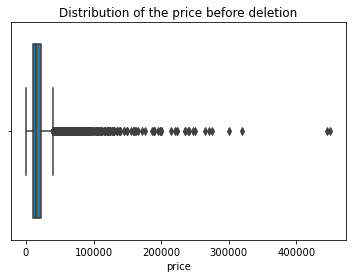

In [245]:
#Investigate price 
price = auto_data.price
sns.boxplot(price)
plt.savefig("Fig1_Price_before_deletion.png")
plt.title("Distribution of the price before deletion")
plt.show()
#so many outliers!

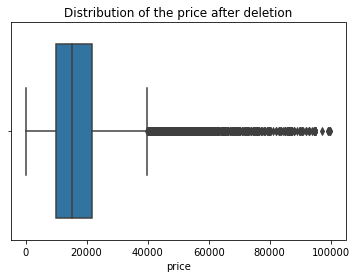

In [246]:
#We do not want to get rid of any vehicles that are in the same price range of the Teslas so we eliminated 
#vehicles under the maximum Tesla price


price_p999 = auto_data['price'].quantile(.999)
auto_data = auto_data[auto_data['price']< price_p999]
price = auto_data['price']
sns.boxplot(x=price)
plt.title("Distribution of the price after deletion")
plt.savefig("Fig2_Price_after_deletion.png")
plt.show()


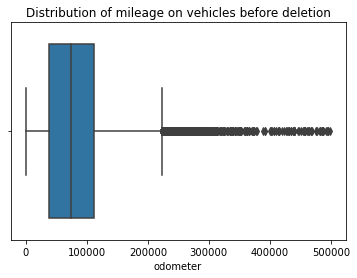

In [247]:
#Investigate Mileage
miles = auto_data.odometer
sns.boxplot(x=miles)
plt.title("Distribution of mileage on vehicles before deletion")
plt.show()
#so many outliers!

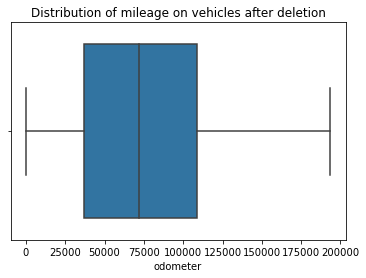

In [248]:
#We eliminate vehicles over the 98th percentile
odometer_p98 = auto_data['odometer'].quantile(.98)

auto_data= auto_data[auto_data.odometer< odometer_p98 ]
miles = auto_data.odometer
sns.boxplot(x=miles)
plt.title("Distribution of mileage on vehicles after deletion")
plt.show()

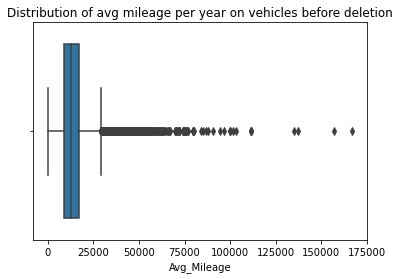

In [249]:
#Investigate Average Mileage using boxplot
avg_miles = auto_data.Avg_Mileage
sns.boxplot(x=avg_miles)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
#so many outliers!

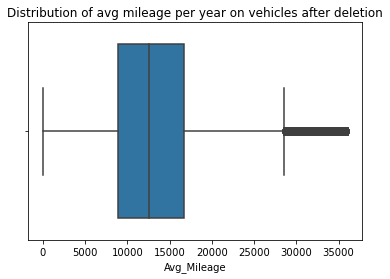

In [250]:
#We eliminate vehicles over the 99th percentile
avm_p99 = auto_data['Avg_Mileage'].quantile(.99)

auto_data= auto_data[auto_data.Avg_Mileage< avm_p99]
avg_miles = auto_data.Avg_Mileage
sns.boxplot(x=avg_miles)
plt.title("Distribution of avg mileage per year on vehicles after deletion")
plt.show()
plt.show()

#Investigate Average Mileage
# Average Milage is the mileage divided by the age let's see that relationship 
g = sns.jointplot(x= 'age', y='odometer',data=auto_data , kind='kde')
_ = g.title = 'Age vs Mileage'
#We van see clustered Non Linear replationsip between age and mileage and some pretty clear boundries

## EDA Explain some of the relationships within the data

In [251]:
auto_data.cylinders.value_counts()

4.000     45675
6.000     43839
8.000     28232
5.000       710
10.000      336
3.000       217
12.000        6
Name: cylinders, dtype: int64

C:\Users\Tiki\anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


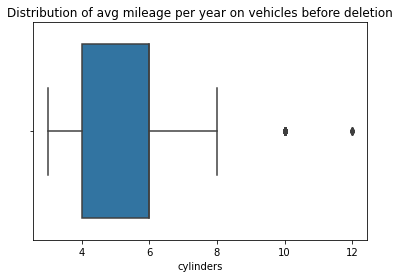

In [252]:
#Check Cylinders
#Investigate cylinders
auto_data['cylinders'] = pd.to_numeric(auto_data['cylinders'])
cylinders = auto_data.cylinders
sns.boxplot(cylinders)
plt.title("Distribution of avg mileage per year on vehicles before deletion")
plt.show()
cylinders.value_counts()
#We eliminate 12 as it only has 8 values 
auto_data =  auto_data[auto_data['cylinders']<12]


<Figure size 1008x864 with 0 Axes>

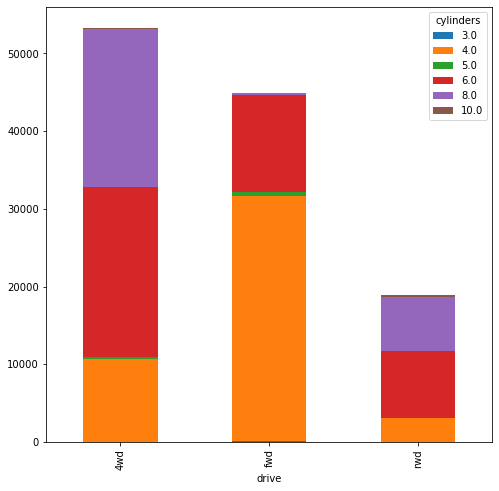

<Figure size 432x288 with 0 Axes>

In [253]:
#There is an interesting relationship between cylinders, and drive
size_type_table = pd.crosstab(index=auto_data["drive"], columns=auto_data["cylinders"])
plt.figure(figsize=(14,12))
size_type_table.plot(kind="bar",  figsize=(8,8), stacked=True)
plt.show()
plt.savefig("cylinder_drive.png")


<Figure size 1008x864 with 0 Axes>

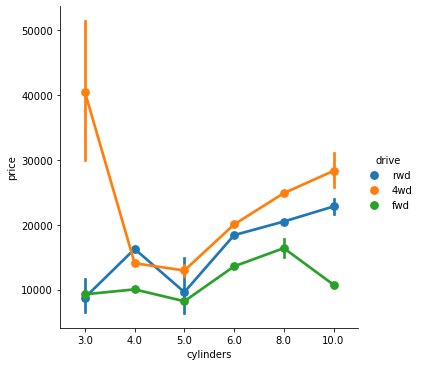

<Figure size 432x288 with 0 Axes>

In [254]:
#There is an interesting relationship between cylinders, drive, mileage and price
plt.figure(figsize=(14,12))
sns.catplot(x="cylinders", y="price", hue='drive', kind='point', data=auto_data)
plt.show()
plt.savefig("cylinder_drive_mileage_price.png")


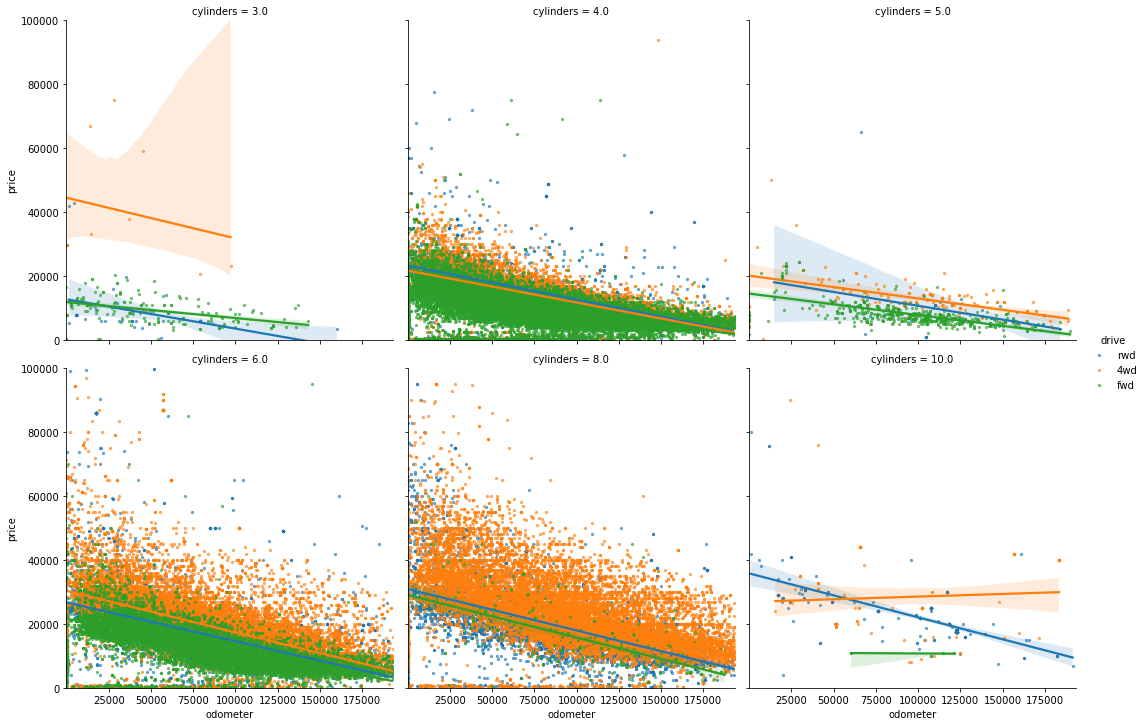

In [255]:
g = sns.lmplot(x= 'odometer', y='price', data=auto_data,  col="cylinders", hue='drive', col_wrap=3, scatter_kws={"alpha":.6, "s": 5})
g = (g.set( ylim=(0, 100000)))

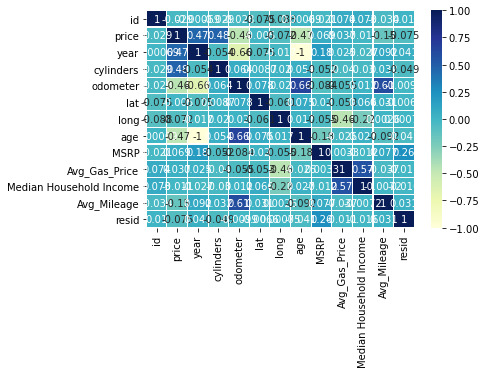

In [256]:
#check for overall correlation relationships

w1 = auto_data.select_dtypes(include=['int64', 'float'])
sns.heatmap(w1.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

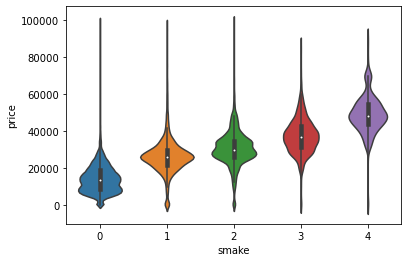

In [257]:
auto_data['smake_0'] = np.where((auto_data['age'] <= 5.5) & (auto_data['cylinders'] == 8), 1, 0)
auto_data['smake_1'] = np.where(((auto_data['drive'] == '4wd') & (auto_data['cylinders'] == 3)) , 1, 0)
auto_data['smake_2'] = np.where((auto_data['drive'] == '4wd') & (auto_data['cylinders'] == 6)  & (auto_data['odometer'] < 25000), 1 , 0)
auto_data['smake_3'] = np.where((auto_data['drive'] == '4wd') & (auto_data['cylinders'] == 8)  & (auto_data['odometer'] < 50000), 1 , 0)


lks= ['Kia', 'Honda', 'Volkswagen', 'Toyota', 'Chrysler'] 
pattern = '|'.join(lks)
auto_data['lk'] = auto_data['manufacturer'].str.contains(pattern)
auto_data['smake_4'] = np.where((auto_data['fuel'] == 'diesel') & (auto_data['lk'] == False) , 2 , 0)

auto_data['smake'] = auto_data['smake_1']+ auto_data['smake_0']+ auto_data['smake_2']+ auto_data['smake_3']+ auto_data['smake_4']
auto_data=auto_data.drop(columns=['smake_1', 'smake_0', 'smake_2', 'smake_3', 'smake_4', 'lk'], axis=1)


auto_data['smake'] = np.where((auto_data['smake'].between(2, 3)) & (auto_data['MSRP'] >45000) & (auto_data['age'] <5) , 4 , auto_data['smake'])
auto_data['smake'] = np.where((auto_data['smake']==1) & (auto_data['MSRP'] >45000), 2 , auto_data['smake'])
auto_data['smake'] = np.where((auto_data['smake'] == 4) & (auto_data['manufacturer'] == 'Nissan'), 2, auto_data['smake'])

ax = sns.violinplot(x='smake', y='price', data=auto_data)

#### Notes
High corelation linear
* Price , MSRP, 
* Price ,  cylinders
* MSRP , cylinders
* Residual,  cylinders
decent correlation 
* Price odometer
* price age
* age odometer (this does not make sense this should have stronger relationship)

In [258]:
# More visuals regarding the distributions are in eda3

## Cleaning Category/ type
* Category refers to the type of design of the vehicle ( examplesedan, hatchback), and it is something people take into consideration while buying a vehicle
* However the naming convention for this is non standard across manufactuers ("pickup" vs "truck" refers to the same type from Ford and GM respectively)
* Considering there are many users on Craigslist even though type is often in the description of a vehicle sold the naming convention would not be consistent from one user description to the next. 
* Since Category type is scraped from the user description means that type is inconsistent across the database

* A Singular third party from an automible expert in this case the USA government will give us a consistent naming convention across all vehicles
* However the goverment gives us a group of possible types a vehicle could be given make model model year

* By combining the user description and the third party categories we get a specific category for each vehicle which has a conistent naming convention across vehicles

* For the merge's we have we are going to check if the category within the description matches what the third party gave


In [259]:
auto_data['type'].value_counts()

Sedan          30832
Suv            27245
Pickup         17456
Truck          13314
Coupe           7175
Other           6353
Hatchback       5119
Van             3913
Wagon           2856
Mini-Van        2416
Convertible     1396
Offroad          189
Bus              128
Name: type, dtype: int64

In [260]:
auto_data['Category'].value_counts()

SUV                                 16305
Sedan                               10912
Sedan, Hatchback                     1568
Sedan, Coupe                         1275
Hatchback                            1238
Wagon                                1231
Van/Minivan                          1143
Pickup                               1026
Coupe, Convertible                    802
Coupe                                 588
Sedan, Wagon                          531
Coupe, Sedan                          321
Hatchback, Sedan                      281
Convertible, Coupe                    242
Sedan, Convertible                    224
Wagon, Sedan                          186
Hatchback, Convertible                157
Sedan, Coupe, Convertible, Wagon      116
Sedan, Coupe, Hatchback               115
Convertible                            92
Sedan, Hatchback, Coupe                64
Sedan, Coupe, Wagon                    50
Sedan, Wagon, Coupe                    45
Coupe, Sedan, Hatchback           

In [261]:
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['Category3']= auto_data['Category'].str.strip().str.split(', ')
auto_data['Category3']= auto_data['Category3'].str.len()
auto_data['type'] = auto_data['type'].replace('Truck', 'Pickup')
auto_data['Category2']= auto_data['Category'].str.strip().str.split(', ').str[0]
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')
auto_data['Categoryf']= auto_data['Category'].fillna('0')
auto_data['typef']= auto_data['type2'].fillna('zzzz')
auto_data['Category_Cleaned1']= np.nan

In [262]:
auto_data['typef'].value_counts()

Sedan          30832
Pickup         30770
Suv            27245
Coupe           7175
zzzz            7159
Van/Minivan     6329
Hatchback       5119
Wagon           2856
Convertible     1396
Bus              128
Name: typef, dtype: int64

In [263]:
#If category length = 1 we do not need to look any further
auto_data['Category_Cleaned'] = np.where(auto_data['Category3'] == 1 , auto_data['Category'], np.nan)
print(auto_data['Category_Cleaned'].isnull().sum())

#check if vehicle type listed in description is the sameone that is in the data replace in that case
auto_data['cat_tiki_check0']= auto_data.apply(lambda x: x.typef in x.Categoryf, axis=1)
auto_data.loc[auto_data['cat_tiki_check0'] == True, 'Category_Cleaned1'] = auto_data.type
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category_Cleaned1'])

#If we can't specify through type and there are only two values listed in Category we pick the first
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['Category2'])


#If we can't specify through type and there more than two values listed in Category we use a cleaned version of type
auto_data['type2']= auto_data['type'].replace('Offroad', np.nan)
auto_data['type2']= auto_data['type2'].replace('Other', np.nan)
auto_data['type2'] = auto_data['type2'].replace('Mini-Van', 'Van')
auto_data['type2'] = auto_data['type2'].replace('Van', 'Van/Minivan')

auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna(auto_data['type2'])
print(auto_data['Category_Cleaned'].isnull().sum())

#If we can't specify through any of the above we call it unlisted
auto_data['Category_Cleaned'] = auto_data['Category_Cleaned'].fillna('Unlisted')


86474
6850


In [264]:
auto_data.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'size', 'type', 'paint_color', 'state', 'lat', 'long', 'age',
       'MSRP', 'Category', 'State ', 'Avg_Gas_Price', 'Division',
       'Median Household Income', 'State_Code', 'Avg_Mileage', 'resid',
       'smake', 'Category2', 'Category3', 'type2', 'Categoryf', 'typef',
       'Category_Cleaned1', 'Category_Cleaned', 'cat_tiki_check0'],
      dtype='object')

In [265]:

auto_data =auto_data.drop(columns = ['Category2', 'type2', 'Category3', 'Categoryf', 'typef', 'cat_tiki_check0', 'Category_Cleaned1'] )


## Feature Selection: Dropping Categorical Variables
* We want to reduce the number of unnecessary variables. Below are some of the reasons:
* We eliminate categorical variables that are included in another variable (aka inter correlation)
    * Example Division, State, and region. As each state has only one division. Each region can only fit in one states
    * We eliminated type and Category as they both fit within Category_cleaned
* We Eliminate categorical variables that are either unique to each vehicle or have too many categories within it because that would create too many dummy variables 
    * There are over 10000 models and while models are not completely unique to each vehicle considering we are trying to determine the asking price when we don't know the value of the model it goes around the point of the study. However again it could be something to look into.
    * There are over 400 regions while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study
    * There are over 50 states while this could be an interesting study we don't need it as we have division, longitude and latitude. It might be something to look into for another study.
* We eliminate variables that have only one value as the don't add anything to the model
    * title status

In [266]:
auto_data.select_dtypes(exclude=['int64', 'float']).nunique()

region               402
manufacturer          38
model               8892
condition              5
fuel                   5
title_status           1
transmission           3
drive                  3
size                   4
type                  12
paint_color           13
state                 51
Category              38
State                 51
Division               9
State_Code            51
smake                  5
Category_Cleaned      11
dtype: int64

In [267]:
#drop categorical variables unique to each entry and/or having over 100 categories within
z2 =auto_data.drop(columns= ['model', 'id' ], axis=1)

##drop state due to combo of intercorrelation 
#z2 =z2.drop(columns= ['region', 'state', 'type', 'Category', 'State_Code', 'State ', 'year'], axis=1)

#drop long, lat due to combo of intercorrelation 
z2 =z2.drop(columns= ['region', 'long', 'lat', 'Division', 'type', 'Category', 'State_Code', 'State ', 'year'], axis=1)


#drop to having only 1 value
z2 =z2.drop(columns= ['title_status'], axis=1)

z2 =z2.drop(columns= ['resid'], axis=1)


In [268]:
z2['size' ]= z2['size'].fillna('unlisted')

In [269]:
#Dropping Nulls- We prefer our data to be without nulls with the exception of MSRP and resid there are few nulls so we eliminate those

z2= z2.dropna()


## Feature manipulation: Cylinders

Cylinders is an nominal variable. That means it is ordinal (1 cylinder < 2 cylinders) but it is non-continous (no such thing as  half a cylinder). This is hard to model. We can either treat it as a categorical varible or we can treat is numerical variable.

Treating cylinders as a categorical variable: 
Pro: No wrong assumptions
Con: Loss of ordering

Treating cylinders as a numerical variable: 
Pro:keep ordering information. It allows us to analyze the data using techniques that  is familiar and easily understandable.
Con: Incorrectly assumes continuosness

First we check if there is a relationship there between the ordinal variable and the dependent variable (Aka cylinders and price). We use a a spearman rank correlation. If that is signifcant we then change the variable into a categorical variable


In [270]:
#See if there i
from scipy.stats import spearmanr
# calculate spearman's correlation
coef, p = spearmanr(z2['price'], z2['cylinders'])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)
    
    #There is 

Spearmans correlation coefficient: 0.511
Samples are correlated (reject H0) p=0.000


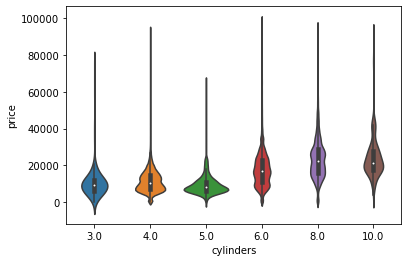

In [271]:
ax = sns.violinplot(x='cylinders', y='price', data=z2)

C:\Users\Tiki\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


price             1900567584
cylinders_3.0            173
cylinders_4.0          44298
cylinders_5.0            693
cylinders_6.0          42165
cylinders_8.0          27150
cylinders_10.0           332
dtype: int64

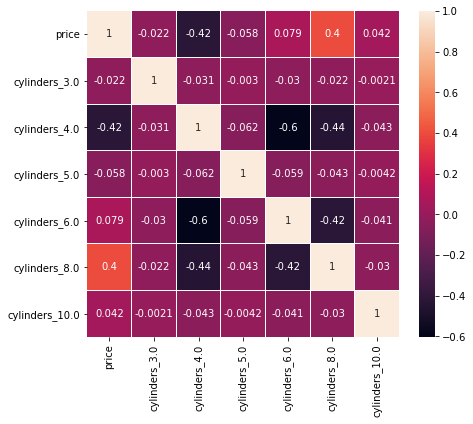

In [272]:
z_cyl=z2[['price', 'cylinders']]
z_cyl['cylinders'] = z_cyl['cylinders'].astype('category')
z_cyl = pd.get_dummies(z_cyl)
plt.figure(figsize=(7,6))
sns.heatmap(z_cyl.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')
z_cyl.sum()

In [273]:
z2['cylinders'] = z2['cylinders'].astype('category')
#drop for intercorrelation


## Feature manipulation: Longitude and Latitude

Longitude and latitude are interrcorelated. While states

from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
grid_params = {'n_neighbors': [5,10,15, 20,25],
               'weights': ['uniform', 'distance'],
               'metric':['euclidean','minkowski', 'manhattan']
              }
long = z2['long'].to_numpy()
lat = z2['lat'].to_numpy() 
gs = GridSearchCV(knn, grid_params, verbose=1, cv=3)
gs_results =gs.fit(long, lat)
gs_results.best_score_
gs_results.best_estimator

## Feature Selection: Dropping Continous Variables
### Eliminate variables due to intercorrelation

We check correlation between our features. We do not want highly correlated variables (aka correlation whose absolute value is of over 0.8 in our data). In our investigation we only find year which is highly correlated to age. We therefore eliminated year from our variables.

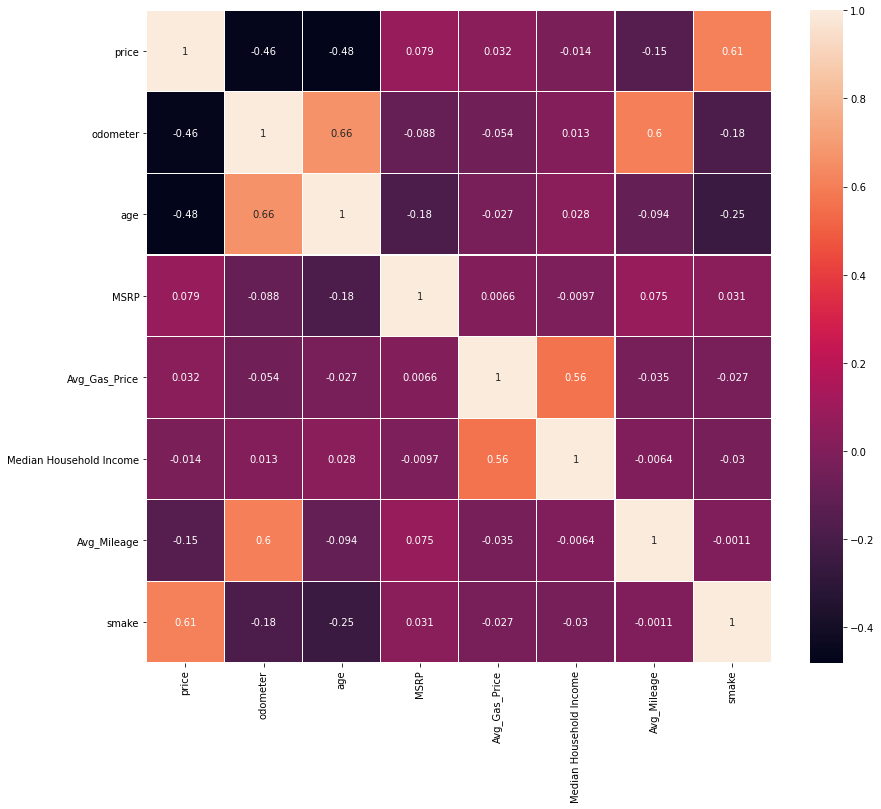

In [274]:
plt.figure(figsize=(14,12))
sns.heatmap(z2.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

We note that there are no variables whose absolute correlation is over 0.8

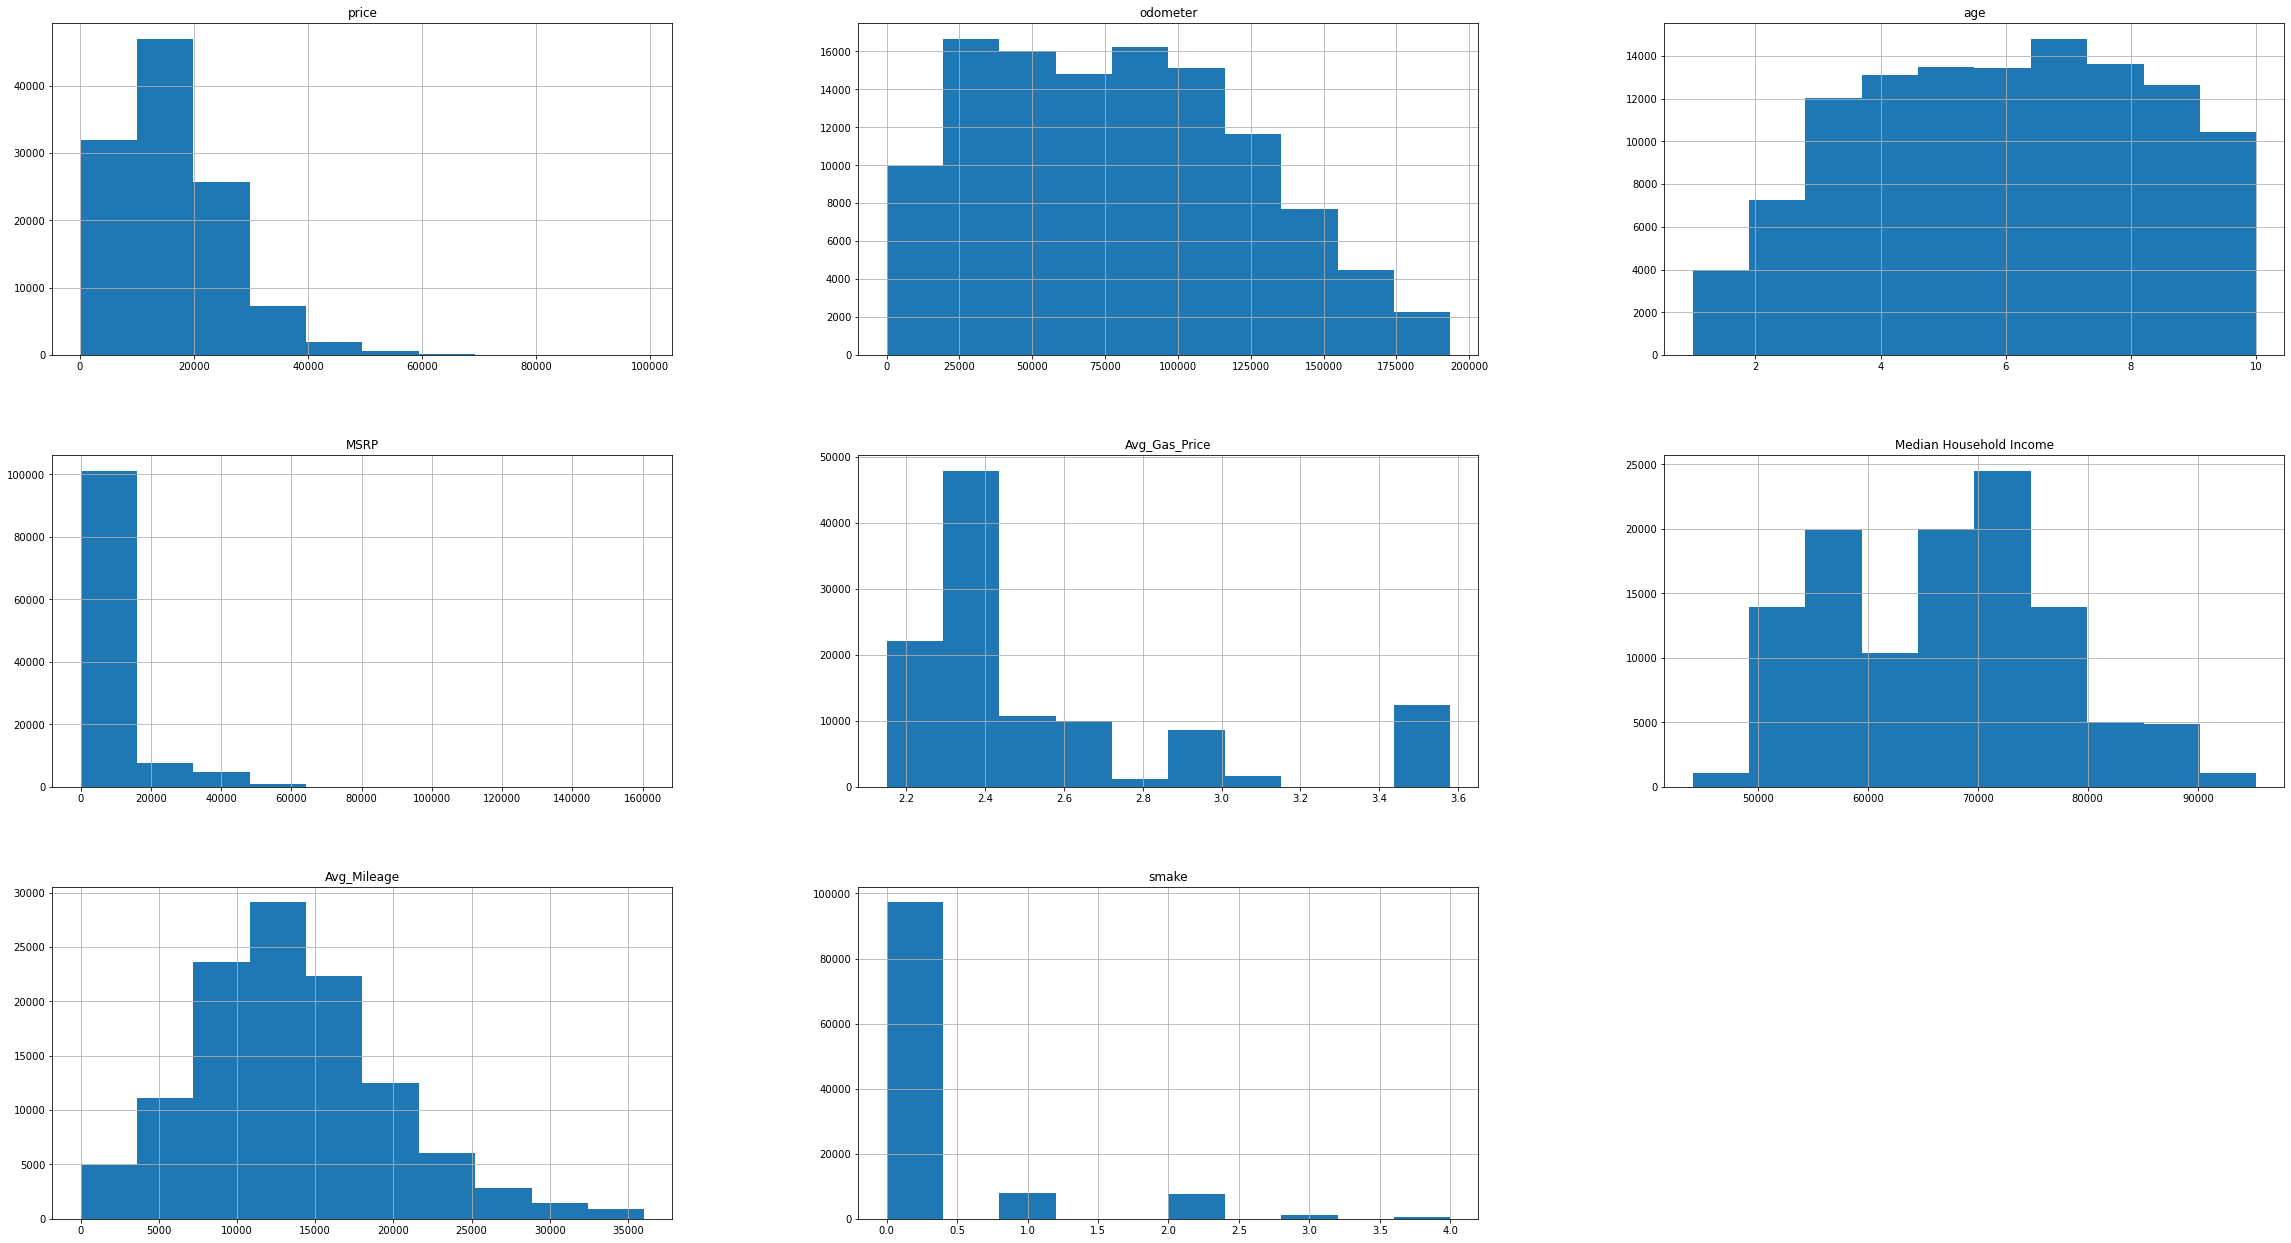

In [275]:

hist = z2.hist(figsize=(40,22))
#The data for price is and age are not a normal destribution so both normalize scaler is bad idea 

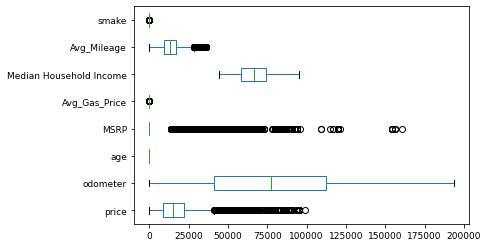

In [276]:
boxplot = z2.boxplot(grid=False, vert=False,fontsize=9)
#No large outliers as that was cleaned out already earlier will not use Robust Scaler

In [277]:
#save data

new_file = 'auto_data_cleaned.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
z2.to_csv(new_file_name_path, index=False)

## Pre Processing the Data

Befeore we can use the data to generate a model we need to make the data able to be understood by the model. In this case we scale the data and turn all our categorical variables into dummy variables. We then seperate the data into our training data and test data.


## Chosing Scaler Standardization

#### Standizing Data
* We have a few methods of standardization to choose from: Robust, Minmax, Normalize and Standardize
* We use Robust if we want to minimize impact of outliers
* We use Normalize if we think the distrubtion within a variable needs to be normalized and/or has a normal distribution
* We use Standardize when we think most of the variables have similar distribution and no/few dummy variables

#### Choosing Min Max Scaler
* The data for price is and age are not a normal destribution we eliminate normalize scaler
* No large outliers as that was cleaned out already earlier we eliminate  Robust Scaler
* As we have dummy variables we can eliminate standard scaler 
* That leaves us with Min Max scaler

## Create Dummy Variables

In [4]:
#Get Path
os.getcwd()
basepath = os.getcwd()
print(basepath)
lis_dir = os.listdir()
print(lis_dir)

# Create the list of file names: filenames
file ='auto_data_cleaned.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
z3 = pd.read_csv(file_name_path)
z3 = z3.reset_index()

C:\Users\Tiki\Documents\Sprinboard2\Capstone_cars
['.ipynb_checkpoints', '575_1100_compressed_data.csv', '575_1100_compressed_data.csv.zip', '62920_1026452_bundle_archive.zip', 'auto trimmed price.ipynb', 'auto1.ipynb', 'auto1_datawrangling.ipynb', 'auto2.ipynb', 'auto2_Combining Data.ipynb', 'auto3.ipynb', 'autodata3_EDA.ipynb', 'autodata4-imputing Data.ipynb', 'autodata4-PCA.ipynb', 'autodata4.ipynb', 'auto_clean.ipynb', 'auto_clean_copy.ipynb', 'auto_clean_copy2-Copy1.ipynb', 'auto_clean_copy2.ipynb', 'auto_clean_copy2_sqrt.ipynb', 'auto_clean_copy3 State vs Region.ipynb', 'auto_clean_copy3- expand tuning-Copy1.ipynb', 'auto_clean_copy3- expand tuning.ipynb', 'auto_clean_p1_cleandata.ipynb', 'auto_clean_p2_mergedata.ipynb', 'auto_clean_p3_impute_data.ipynb', 'auto_clean_p4_EDA.ipynb', 'CapstoneProjectSlides_example.pdf', 'correlation.png', 'cylinder_drive.png', 'cylinder_drive_mileage_price.png', 'data', 'Feature Importance.png', 'Fig1_Price_before_deletion.png', 'Fig2_Price_after_d

In [5]:
#shrink data where we can
categorical_columns = z3.select_dtypes(exclude=['int64', 'float']).columns.tolist()
for col in categorical_columns:
    z3[col] = z3[col].astype('category')
    
z3['cylinders'] = z3['cylinders'].astype('category')
z3.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114811 entries, 0 to 114810
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   index                    114811 non-null  int64   
 1   price                    114811 non-null  int64   
 2   manufacturer             114811 non-null  category
 3   condition                114811 non-null  category
 4   cylinders                114811 non-null  category
 5   fuel                     114811 non-null  category
 6   odometer                 114811 non-null  float64 
 7   transmission             114811 non-null  category
 8   drive                    114811 non-null  category
 9   size                     114811 non-null  category
 10  paint_color              114811 non-null  category
 11  state                    114811 non-null  category
 12  age                      114811 non-null  float64 
 13  MSRP                     114811 non-null  fl

In [6]:
kw= ['Mercedes-Benz', 'Bmw', 'Audi', 'Land-Rover', 'Lexus', 'Acura', 'Jaguar']
qw= ['Alfa-Romeo', 'Tesla', 'Porsche']
z3['Lux'] = z3['manufacturer'].apply(lambda x: any([k in x for k in kw])).astype(int)
z3['sLux'] = z3['manufacturer'].apply(lambda x: any([q in x for q in qw])).astype(int)

In [23]:
z3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114811 entries, 0 to 114810
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   index                    114811 non-null  int64   
 1   price                    114811 non-null  int64   
 2   manufacturer             114811 non-null  category
 3   condition                114811 non-null  category
 4   cylinders                114811 non-null  category
 5   fuel                     114811 non-null  category
 6   odometer                 114811 non-null  float64 
 7   transmission             114811 non-null  category
 8   drive                    114811 non-null  category
 9   size                     114811 non-null  category
 10  paint_color              114811 non-null  category
 11  state                    114811 non-null  category
 12  age                      114811 non-null  float64 
 13  MSRP                     114811 non-null  fl

In [7]:
#create dummy variables
Category_Cleaned = z3['Category_Cleaned']
auto_data_dummies= pd.get_dummies(z3) #changed from z2


In [8]:
new_file = 'auto_data_dummies.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
auto_data_dummies.to_csv(new_file_name_path, index=False)

In [9]:
df =auto_data_dummies.corr(method ='pearson')
df = df[((df > 0.7) | (df < -0.7)) & (df != 1)]
non_empty_cols = [col for col in df.columns if ~df[col].isnull().all()]
empty_cols = [col for col in df.columns if df[col].isnull().all()]

## Pre Processing Feature Selection: Dropping Dummy Variables
### Eliminate variables due to intercorrelation


1) Group Intercorrelation
When we have a categorical variables and convert them into dummies we can cannot have all the dummies in the group since  the last dummy variable will be a linear combination of the other dummies. So we eliminate one variable from the group.

2) Eliminate variables where absolute correlation is greater 0.8

['price', 'odometer', 'age', 'MSRP', 'Avg_Gas_Price', 'Median Household Income', 'Avg_Mileage', 'smake', 'Lux']
['manufacturer_Tesla', 'manufacturer_Toyota', 'manufacturer_Volkswagen', 'manufacturer_Volvo', 'condition_excellent', 'condition_fair', 'condition_like new', 'condition_new', 'cylinders_3.0', 'cylinders_4.0', 'cylinders_6.0', 'cylinders_8.0', 'cylinders_10.0', 'fuel_electric', 'fuel_gas', 'fuel_hybrid', 'fuel_other']


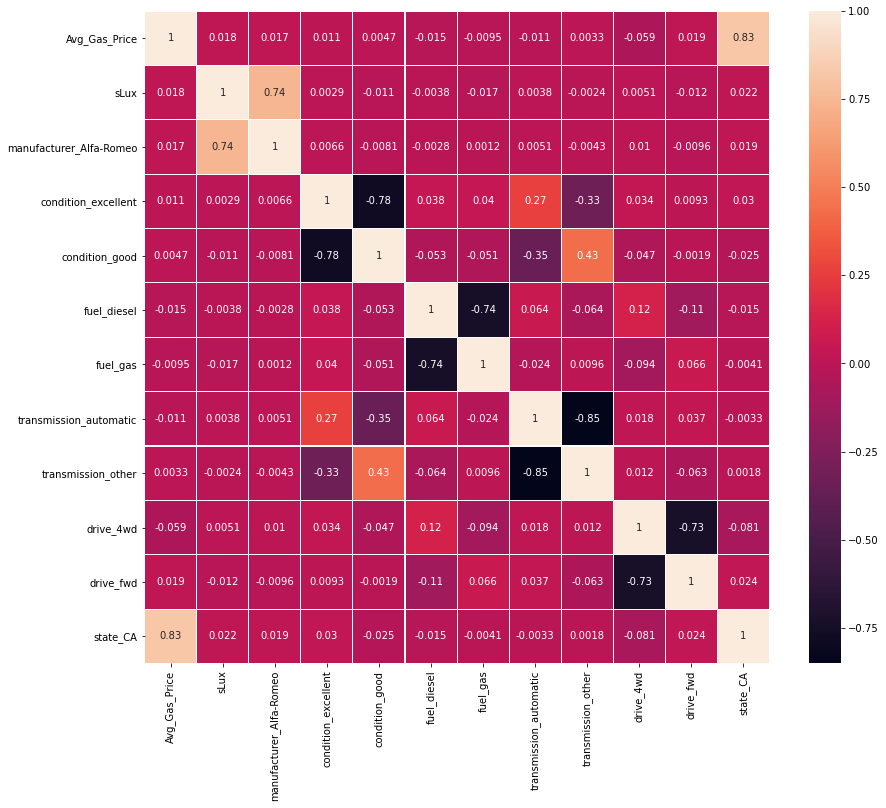

In [10]:
auto_data_dummies_small = auto_data_dummies.drop(columns= empty_cols)
plt.figure(figsize=(14,12))
sns.heatmap(auto_data_dummies_small.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

#Eliminate variables where absolute correlation is greater 0.8
auto_data_dummies2= auto_data_dummies.drop(columns= ['condition_good', 'fuel_diesel', 'transmission_other', 'drive_fwd', 'state_CA']) 

#eliminateto mass dummy intercorrelation
auto_data_dummies2= auto_data_dummies2.drop(columns= ['size_mid-size', 'paint_color_red', 'manufacturer_Infiniti', 'cylinders_5.0', 'index']) 

ac= auto_data_dummies2.columns.tolist()
print(ac[:9])
print(ac[43:60])

In [11]:
auto_data_dummies2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114811 entries, 0 to 114810
Columns: 141 entries, price to Category_Cleaned_Wagon
dtypes: float64(6), int32(2), int64(2), uint8(131)
memory usage: 22.2 MB


## Seperate Data for Train, Test, and Validate

In [12]:
#seperate X and y from each other
X = auto_data_dummies2
print(type(X))
y = auto_data_dummies2['price']

X =X.drop(columns=['price'], axis=1)

#split train, test and vals

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.25, random_state=42)


# Create val and train sets
X_train, X_test2, y_train, y_test2 = train_test_split(X_train, y_train, test_size = 3/11, random_state=42)

<class 'pandas.core.frame.DataFrame'>


## Use the MinMax Scaler on Data

In [13]:
#standardize numeric variables
from sklearn.preprocessing import MinMaxScaler

#create scaler
scaler = MinMaxScaler()

#Scale numeric data1
X_train_mm = scaler.fit_transform(X_train)
X_test_mm = scaler.transform(X_test)

In [14]:
df_cl_list=X_train.columns.tolist()
df3 = pd.DataFrame(X_train_mm, columns = df_cl_list)
df3 = df3.iloc[:, : 7]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62624 entries, 0 to 62623
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   odometer                 62624 non-null  float64
 1   age                      62624 non-null  float64
 2   MSRP                     62624 non-null  float64
 3   Avg_Gas_Price            62624 non-null  float64
 4   Median Household Income  62624 non-null  float64
 5   Avg_Mileage              62624 non-null  float64
 6   smake                    62624 non-null  float64
dtypes: float64(7)
memory usage: 3.3 MB


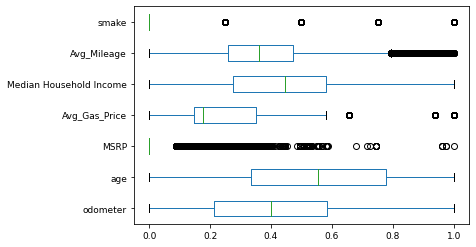

In [15]:
boxplot = df3.boxplot(grid=False, vert=False,fontsize=9)

In [16]:
from sklearn.linear_model import Ridge
#ridge = Ridge(solver='svd')
#ridge1 = Ridge(solver='svd')  
    

ridge = Ridge(solver='lsqr') #fastest solver for Ridge Regression
ridge1 = Ridge(solver='lsqr') #fastest solver for Ridge Regression 
    
    
#Instantiate and fit a ridge reg to the min_max scaled data
ridge_scaled = ridge.fit(X_train_mm, y_train)


# Instantiate and fit ridge reg classifier to the unscaled data
ridge_unscaled = ridge1.fit(X_train, y_train)


# Compute and print metrics
print('Accuracy with Min Max Scaling: {}'.format(ridge_scaled.score(X_test_mm, y_test)))
print('Accuracy without Scaling: {}'.format(ridge_unscaled.score(X_test, y_test)))


Accuracy with Min Max Scaling: 0.7099953298456982
Accuracy without Scaling: 0.23999809512167336


## Testing Models

## Comparison of the models:

We tested 10 different regression models 
* Linear Regression
* Linear Log Regression
* Ridge Regression
* Elasticnet Regression
* Decision Tree Regression
* Extra Tree Regression
* Gamma Regression
* Ridge with PCA
* Linear with PCA
* elasticnet with PCA

We Test with Two parameterrs
* Median Absolute Error: MAE
* Mean Percentage Error: MPE

Our dealer is using our prediction to decide if the asking price is lower than the predicted price he could get on Craig's list. The dealer is risk averse he does not want to take the deal if there is a high chance that the predicted price he is using is larger than the actual price. Therefore between two equally accurate models he would prefer if the  predictions under valued the car then over valued the car.

The Median Absolute Error (MAE) is useful for just getting an overall fit of the model.It is a quick and easy way to compare how well one model does versus the other. Further it is not effected by the number of parameters as say R squared. This will give us the close prediction that we want. The closer the MAE

The Median Percentage Error (MPE) tells us if our regression over estimates (positve MPE) or under estimates (negative MPE).  Between two similar models in accordance to our dealer's risk aversion we prefer a negative MPE. 

For More Information:

https://www.dataquest.io/blog/understanding-regression-error-metrics/


#### Base testing Creating MPE , MAE, and comparison charts

We are going to put some restraints on the prediction. We know that the minimum price of the car is 0. So when we take the regressions we will zero out and predictions greater than 0.

In [17]:
from sklearn.metrics import make_scorer, median_absolute_error, mean_absolute_error

#Create MAE loss function
def MedianAbsoluteError(real:np.ndarray, predicted:np.ndarray) -> np.float64:
    """
    The Mean (MAE) metric 
    :param real: The ground truth labels given in the dataset
    :param predicted: Our predictions
    :return: The Mean Absolute Error Score
    """
    predicted[predicted<0] = 0
    return median_absolute_error(real, predicted)

#Create MPE loss function
def MPE_func(real, predicted):
    """
    The Median (MAE) metric 
    :param real: The ground truth labels given in the dataset
    :param predicted: Our predictions
    :return: The Median Percentage Error Score
    """
    predicted[predicted<0] = 0
    return np.median((predicted- real)/real)

#Turn MAE and MPE into scorers
mae = make_scorer(MedianAbsoluteError, greater_is_better=False)
mpe = make_scorer(MPE_func, greater_is_better=False)

def quick_run(estimatorx, X_train, y_train, X_test, y_test, folds=5, name_g= 'default'):
    """
    Put in X and Y train and test values as well as the estimator
    ___
    Returns:  Y_ predictions and cross validated statistics
    """
 
    #fit estimate
    estimatorx.fit(X_train, y_train)
        
    # Predict using model:
    y_predict= estimatorx.predict(X_train)
    y_predict_test = estimatorx.predict(X_test)
    y_predict[y_predict<0] = 0 #The minimum price for a car is 0
    y_predict_test[y_predict_test<0] = 0 #The minimum price for a car is 0   
    
    from sklearn.model_selection import cross_val_score
    #Cross validate scores for rmsle
    #cv_scores_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=rmsle_score)
    #cv_scores_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=rmsle_score)
    
    cv_scores_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=mpe)
    cv_scores_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=mpe)
    
    #Cross validate scores for R2
    cv_mae_train = cross_val_score(estimator= estimatorx, X=X_train, y=y_train, cv=folds, scoring=mae)
    cv_mae_test = cross_val_score(estimator= estimatorx, X=X_test, y=y_test, cv=folds, scoring=mae)
    
    #get stats for cross validated scored mpe
    
    cv_scores_test_mean= cv_scores_test.mean()
    cv_scores_train_mean= cv_scores_train.mean()
    cv_scores_test_std= cv_scores_test.std()
    
    #get stats for cross validated scored mae
    #because in our scorer we used "greater"
    cv_mae_test_mean= -cv_mae_test.mean()
    cv_mae_train_mean= -cv_mae_train.mean()
    cv_mae_test_std= cv_mae_test.std()
    if name_g == 'default':
        name_reg = str(estimatorx)
    else:
        name_reg = name_g
    c= [name_reg,cv_mae_train_mean,  cv_mae_test_mean, cv_mae_test_std, cv_scores_train_mean, cv_scores_test_mean, cv_scores_test_std]
    

    print('Cross Validated Scores for regression equation: {} '.format(name_reg))
    print('Median Absolute Error: ')
    print ('Mean train score: ${:.0f} '.format(cv_mae_train_mean))
    print ('Mean test score: ${:.0f} '.format(cv_mae_test_mean))
    print ('Standard Deviation test score: ${:.0f} '.format(cv_mae_test_std))
    print('')
    print('MPE: ')
    print ('Mean train score: {:.5f} '.format(cv_scores_train_mean))
    print ('Mean test score: {:.5f} '.format(cv_scores_test_mean))
    print ('Standard Deviation test score: {:.5f} '.format(cv_scores_test_std))
    print('')
    diff = y_test -y_predict_test

    
    fig, axs = plt.subplots(2, 2, figsize=(14,5), sharey=True) #Create two sub plots sharing x and y axis
    fig.suptitle('Error in Price Prediction for {} Regression'.format(name_reg), fontsize=16, y=1 , x= 0.45)
    
    #plt scatter
    from scipy.stats import kde
    
    ax1 = plt.subplot(121)
    #sc= plt.scatter(y_test, diff, s= 1, c= cylinders_z)
    sc= plt.scatter(y_test, diff, s= 2, alpha=0.2)
    y_test_lim_up = y_test.quantile(.99)
    y_test_lim_down = y_test.quantile(.01)
    plt.xlim(y_test_lim_down, y_test_lim_up)
    plt.title('Actual Price vs Error')
    plt.ylabel('Error in $ ')
    plt.xlabel('Actual Price in $')
    plt.box(on=None)
    #cbar= plt.colorbar(sc)
    #cbar.set_label('# of cylinders', rotation=90)

    
    ax2 = plt.subplot(122)
    diff.hist(bins = 50, orientation='horizontal')
    plt.title('Histogram of Error')
    plt.ylabel('Error in $ ')
    plt.xlabel('Frequency')
    plt.box(on=None)
    plt.grid(color='white')
    plt.show()  
    

   
    return y_predict_test, c



In [18]:
def quick_grind(params, model, X_train, y_train):
    """
    put in parameter grid and estimator
    ___
    Returns:  Optimized parameters, Y_ predictions and cross validated statistics
    """
 
    #fit estimate
    model_GS = GridSearchCV(model, param_grid=params, cv=3, verbose=3, n_jobs=-1, scoring= mae)
    model_GS.fit(X_train, y_train)
    q=model_GS.best_params_
    return q, model_GS


#### Base testing 1 - Linear

Cross Validated Scores for regression equation: Linear 
Median Absolute Error: 
Mean train score: $2248 
Mean test score: $2299 
Standard Deviation test score: $27 

MPE: 
Mean train score: -0.00387 
Mean test score: -0.00104 
Standard Deviation test score: 0.00439 



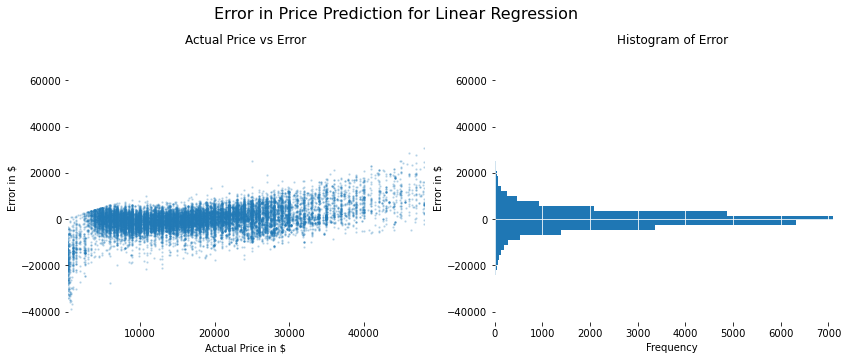

In [19]:
# Apply Linear model to training data:
linear = LinearRegression() 
y_predict_test_linear, c_linear = quick_run(linear, X_train_mm, y_train, X_test_mm, y_test, name_g= 'Linear')

#### Base testing 2 - Linear_Log

Cross Validated Scores for regression equation: Linear Log 
Median Absolute Error: 
Mean train score: $0 
Mean test score: $0 
Standard Deviation test score: $0 

MPE: 
Mean train score: 0.00579 
Mean test score: 0.00618 
Standard Deviation test score: 0.00050 



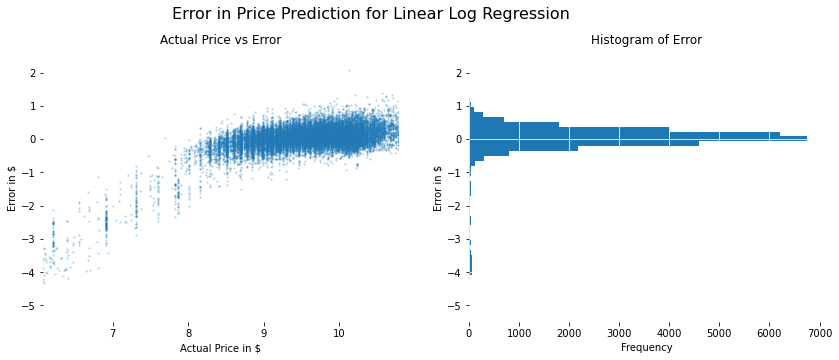

In [293]:
# Apply Linear Log model to training data:
linlog = LinearRegression() #previous optimization different study
y_train_lg = np.log(y_train)
y_test_lg = np.log(y_test)
y_predict_test_linlog, c_linlog = quick_run(linlog, X_train_mm, y_train_lg, X_test_mm, y_test_lg, name_g ='Linear Log')


#### Base testing 3 - Ridge

In [294]:
#Parameters for Ridge Hypertuning
params_ridge = {'alpha': [10, 1, 0.1, 0.01, 0.001], 'solver': ['svd', 'lsqr', 'cholesky'], 'fit_intercept': [True, False]}
model_ridge = Ridge()
q_ridge, model_ridgeft = quick_grind(params_ridge, model_ridge,  X_train_mm, y_train)
# Apply Ridge model to training data:
ridge_opt = Ridge(**model_ridgeft.best_params_)



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.4min finished


Cross Validated Scores for regression equation: Ridge 
Median Absolute Error: 
Mean train score: $2245 
Mean test score: $2294 
Standard Deviation test score: $27 

MPE: 
Mean train score: -0.00447 
Mean test score: -0.00179 
Standard Deviation test score: 0.00410 



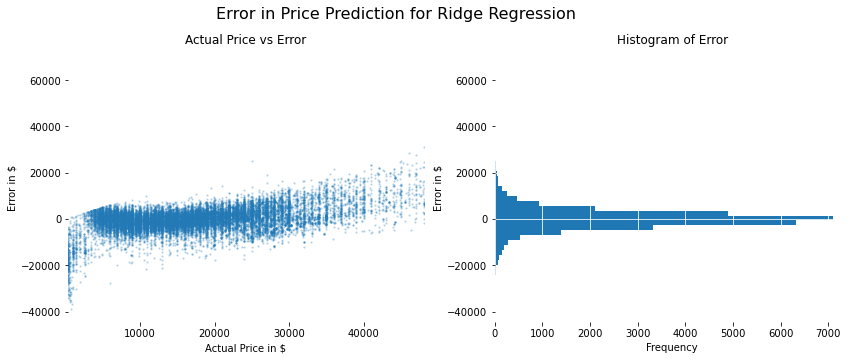

In [295]:
y_predict_test_ridge, c_ridge = quick_run(ridge_opt, X_train_mm, y_train, X_test_mm, y_test, name_g= 'Ridge')


#### Base testing 4 - Elasticnet

In [296]:
params_elastic = {'l1_ratio': [0, .1, .5, .7, .9, 1], 'alpha': [10, 1, 0.1, 0.01], 'fit_intercept': [True, False]}
model_elastic = ElasticNet()
q_elastic, model_ft = quick_grind(params_elastic, model_elastic,  X_train_mm, y_train)
# Apply Elastic Net hyper tuned parameters to training data:
elastic_opt = ElasticNet(**model_ft.best_params_)
print(q_elastic)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 10.3min finished


{'alpha': 0.01, 'fit_intercept': True, 'l1_ratio': 0.9}


Cross Validated Scores for regression equation: ElasticNet 
Median Absolute Error: 
Mean train score: $2236 
Mean test score: $2289 
Standard Deviation test score: $27 

MPE: 
Mean train score: -0.00588 
Mean test score: -0.00303 
Standard Deviation test score: 0.00364 



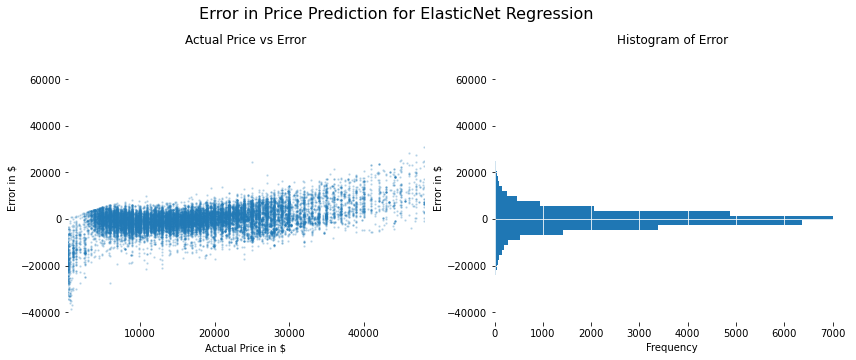

In [297]:
y_predict_test_elastic, c_elastic = quick_run(elastic_opt, X_train_mm, y_train, X_test_mm, y_test,  name_g= 'ElasticNet')


#### Base Testing 5- Gamma Regression

In [298]:
from sklearn.linear_model import GammaRegressor
params_gamma = {'alpha': [1, 0.5, 0.3, 0.1, 0.05, 0], 'fit_intercept': [True, False], 'warm_start':[True, False] }
model_gamma = GammaRegressor(max_iter=200)
q_gamma, model_ft = quick_grind(params_gamma, model_gamma,  X_train_mm, y_train)
print(q_gamma)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   43.7s finished


{'alpha': 0, 'fit_intercept': False, 'warm_start': True}


C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)


C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_glm\glm.py:285: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the da

Cross Validated Scores for regression equation: Gamma 
Median Absolute Error: 
Mean train score: $2203 
Mean test score: $2216 
Standard Deviation test score: $38 

MPE: 
Mean train score: -0.01140 
Mean test score: -0.01243 
Standard Deviation test score: 0.00594 



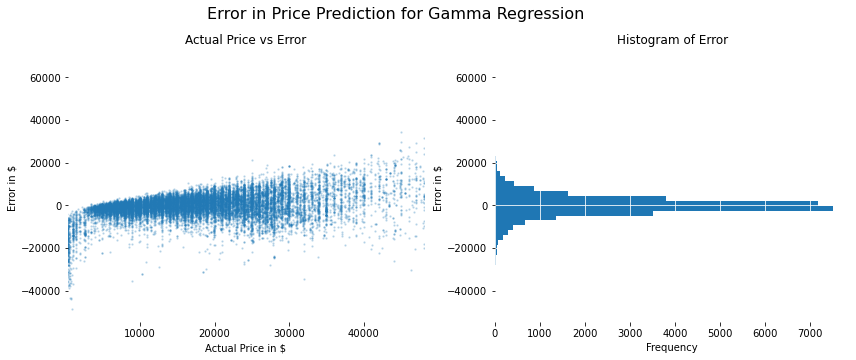

In [299]:
# Apply gamma hyper tuned parameters to training data:
gamma_opt = GammaRegressor(**model_ft.best_params_)
y_predict_test_gr, c_gr = quick_run(gamma_opt, X_train_mm, y_train, X_test_mm, y_test, name_g= 'Gamma')

#### Base Testing 6- Extra Tree Regression

In [20]:
from sklearn.tree import ExtraTreeRegressor
model_ext = ExtraTreeRegressor()
#Parameter grid search extra tree
params_ext= { 'min_samples_leaf': range(3,38,5), 'min_samples_split': range(15,36,10), 'max_depth': [25, 30]}                           


In [21]:

q_ext, model_ft_ext = quick_grind(params_ext, model_ext,  X_train_mm, y_train)
print(q_ext)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 126 out of 126 | elapsed:  1.3min finished


{'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 15}


Cross Validated Scores for regression equation: Extra Tree 
Median Absolute Error: 
Mean train score: $1540 
Mean test score: $1848 
Standard Deviation test score: $23 

MPE: 
Mean train score: 0.00000 
Mean test score: 0.00055 
Standard Deviation test score: 0.00076 



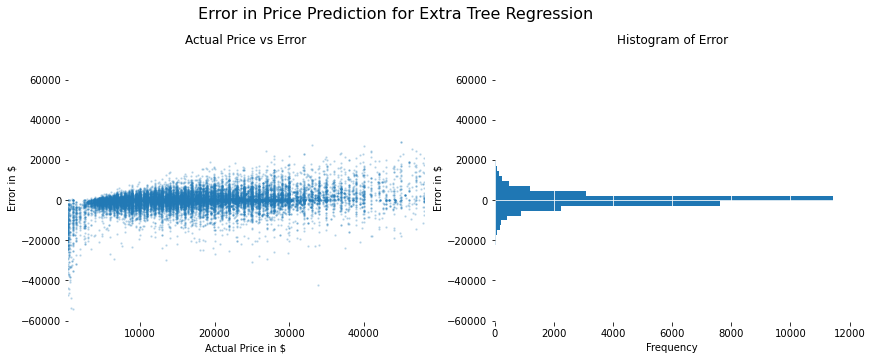

In [22]:
#Apply Hyperparameters to training data
ext_opt = ExtraTreeRegressor(**model_ft_ext.best_params_)

y_predict_test_ext, c_ext = quick_run(ext_opt, X_train_mm, y_train, X_test_mm, y_test,  name_g= 'Extra Tree')


In [303]:
from sklearn.ensemble import RandomForestRegressor
model_randf = RandomForestRegressor()
#Parameter grid search extra tree
params_randf= {'min_samples_leaf': range(5,21,5), 'min_samples_split': range(15,36,10), 'max_depth': [20, 25, 30]}                           

q_randf, model_ft_rf = quick_grind(params_randf, model_randf,  X_train_mm, y_train)
print(q_randf)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 38.3min finished


{'max_depth': 25, 'min_samples_leaf': 5, 'min_samples_split': 15}


In [304]:
#Apply Hyperparameters to training data
randf_opt =  RandomForestRegressor(**model_ft_rf.best_params_)
#randf_opt =  RandomForestRegressor(min_samples_split=5, min_samples_leaf=15)

Cross Validated Scores for regression equation: Random Forest 
Median Absolute Error: 
Mean train score: $1381 
Mean test score: $1641 
Standard Deviation test score: $32 

MPE: 
Mean train score: -0.00105 
Mean test score: -0.00095 
Standard Deviation test score: 0.00156 



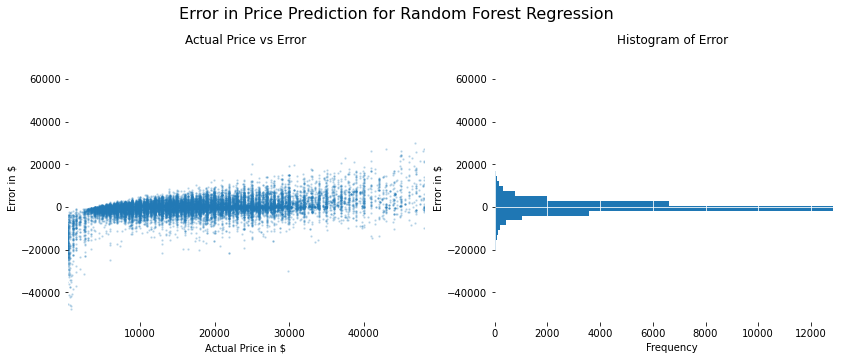

In [305]:

y_predict_test_randf, c_randf = quick_run(randf_opt, X_train_mm, y_train, X_test_mm, y_test,  name_g= 'Random Forest')

#### Base testing 8 - Linear PCA

Cross Validated Scores for regression equation: PCA Linear 
Median Absolute Error: 
Mean train score: $2752 
Mean test score: $2755 
Standard Deviation test score: $15 

MPE: 
Mean train score: -0.01540 
Mean test score: -0.01441 
Standard Deviation test score: 0.00496 



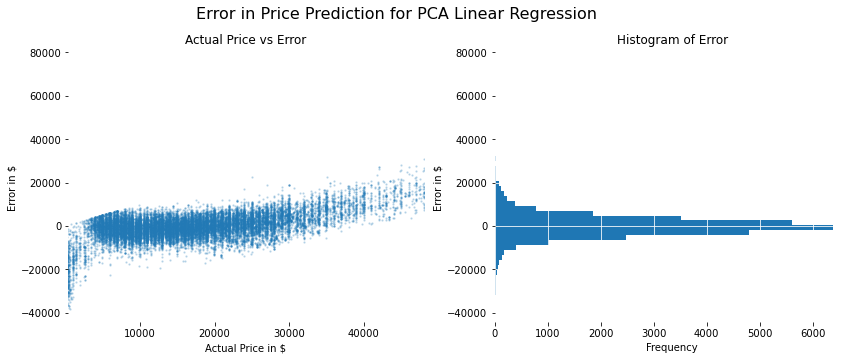

In [306]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA() 
linear_dg= LinearRegression()
pipe_linear = Pipeline(steps=[('pca', pca), ('linear', linear_dg)])
param_grid = {'pca__n_components':  list(range(1,20,2)) ,}
linear_pca = GridSearchCV(pipe_linear, param_grid, cv=5, scoring= mae)
linear_pca.fit(X_train_mm, y_train)
pipe_linear = linear_pca.best_estimator_
y_predict_test_pca_lin, c_pca_lin = quick_run(pipe_linear, X_train_mm, y_train, X_test_mm, y_test, name_g= 'PCA Linear')

#### Base testing 9 - Elasticnet PCA

In [307]:
elastic_dg= ElasticNet( selection= 'random' )
pipe_elastic = Pipeline(steps=[('pca', pca), ('elastic', elastic_dg)])

param_grid = {'pca__n_components':  list(range(1,20,3)) , 'elastic__l1_ratio': [0, .5, .1], 
              'elastic__alpha': [10, 1, 0.1]}


In [308]:
elastic_pca = GridSearchCV(pipe_elastic, param_grid, cv=5, scoring= mae)
elastic_pca.fit(X_train_mm, y_train)
pipe_p = elastic_pca.best_estimator_

C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2312505060825.8066, tolerance: 471089346.7142323
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2322277317173.3105, tolerance: 473167745.1882402
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2306021294209.2827, tolerance: 469761811.13914907
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2292800414693.297, tolerance: 469761811.13914907
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2321688400490.883, tolerance: 475642385.6564854
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2320832683859.004, tolerance: 475536485.4838465
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208

C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2020734887906.9822, tolerance: 475642385.6564854
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2019143773360.9617, tolerance: 475536485.4838465
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1971395856670.8838, tolerance: 471089346.7142323
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1547059787145.9387, tolerance: 475536485.4838465
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1460275512378.8103, tolerance: 471089346.7142323
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1464940583802.3125, tolerance: 473167745.1882402
  positive)
C:\Users\Tiki\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1

Cross Validated Scores for regression equation: PCA Elastic 
Median Absolute Error: 
Mean train score: $2748 
Mean test score: $2790 
Standard Deviation test score: $26 

MPE: 
Mean train score: -0.03857 
Mean test score: -0.03585 
Standard Deviation test score: 0.00509 



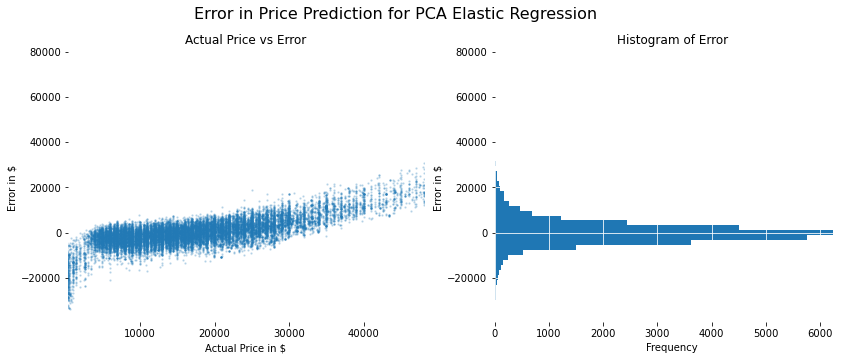

In [309]:

y_predict_test_pca_elastic, c_pca_elastic = quick_run(pipe_p, X_train_mm, y_train, X_test_mm, y_test, name_g= 'PCA Elastic')


### Comparing Models

#### Comparing Models table

In [310]:
score_columns= ['Algorithm', 'MAE Train', 'MAE Test',  'MAE Test std', 'MPE Train', 'MPE Test',  'MPE Test std']
c_data =[c_linear, c_ridge, c_elastic, c_randf, c_ext, c_gr, c_pca_lin, c_pca_elastic]
convert_dict = {'MAE Train': int, 'MAE Test': int} 
score_tab = pd.DataFrame(c_data, columns= score_columns )
score_tab = score_tab.astype(convert_dict) 
pd.options.display.float_format = '{:.3f}'.format



new_file = 'model_comparison.csv'
new_file_name_path = os.path.join(basepath,sub_file, new_file)
score_tab.to_csv(new_file_name_path, index=False)

score_tab.sort_values('MAE Test')

,Algorithm,MAE Train,MAE Test,MAE Test std,MPE Train,MPE Test,MPE Test std
3,Random Forest,1380,1641,31.602,-0.001,-0.001,0.002
4,Extra Tree,1540,1889,20.887,0.000,0.000,0.001
5,Gamma,2203,2215,38.075,-0.011,-0.012,0.006
2,ElasticNet,2235,2289,27.372,-0.006,-0.003,0.004
1,Ridge,2244,2294,26.612,-0.004,-0.002,0.004
0,Linear,2247,2299,25.976,-0.004,-0.001,0.004
6,PCA Linear,2752,2754,15.473,-0.015,-0.014,0.005
7,PCA Elastic,2748,2790,25.902,-0.039,-0.036,0.005


#### Comparing Models Graph

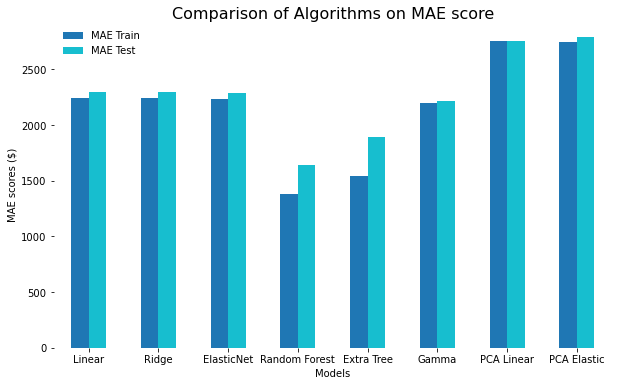

In [311]:
from matplotlib import cm
score_tab_MAE= score_tab[['Algorithm','MAE Train', 'MAE Test']].set_index('Algorithm')
cmap = cm.get_cmap('tab10') 

ax=score_tab_MAE.plot.bar(rot=0, figsize=(10,6), cmap=cmap )

plt.title('Comparison of Algorithms on MAE score', fontsize=16, pad=0.1)
plt.legend(frameon= False)
plt.box(on=None)
plt.xlabel('Models',fontsize=10)
plt.ylabel ('MAE scores ($)',fontsize=10)
plt.savefig("Figx_ModelComparison.png")


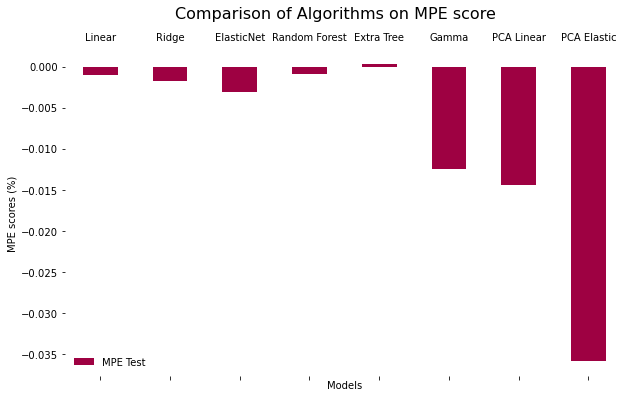

In [312]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral')

score_tab_MPE= score_tab[['Algorithm','MPE Test']].set_index('Algorithm')



ax=score_tab_MPE.plot.bar(rot=0, figsize=(10,6), cmap=cmap )
ax.tick_params(labelbottom=False,labeltop=True)
plt.suptitle('Comparison of Algorithms on MPE score', fontsize=16,)

plt.xlabel('Models',fontsize=10)
plt.ylabel ('MPE scores (%)',fontsize=10)
plt.legend(frameon= False)
plt.box(on=None)
plt.savefig("Figx_ModelComparison_MPE.png")


#### Winner Algorithm: Random Forest Regression

As we look at the 9 models we find a two overall trends:
* All of these models over estimate versus under estimate (MPE is negative).
* Models error is correlated to explanotry variable (price).

Within these nine models we can group them into PCA, Linear Type and Ensemble:
* Models with the PCA have hive higher MAE and the absolute value of their MPE is larger than the other models so we eliminate
* 3 Linear Type regressions (Elastic, Linear and Ridge) have very similar MAE results around ()
* Of the linear type of regressions Gamma had the best results. That makes sense as the explanatory variable (price) does not have a normal distribution but skews left.
* Ensumble methods (Random Forest and Extra Tree) have 
    * The best MAE and MPE scores
    * The least price to error correlation 

Within Ensemble Methods:
* Random Forest Regression  MAE Test results are better than Extra Tree train scores
* Random Forest Regression  MPE Test results are within Exra Tree MPE test results + strandard deviation
* We therefore pick Randon Forest Regression.


## Optimizing Random Forest 

Now that we know that Random Forest looks like the best model we use a grid search to find the best parameter. 
We look in particular at the minimum samples per leaf, maximum number of feat. and minimum number of splits.

### Hyperparameter Tuning: Random Forest

In [313]:
from sklearn.ensemble import RandomForestRegressor
model_randf = RandomForestRegressor(n_estimators=150, max_depth=30)
#Parameter grid search extra tree
params_randf= {'min_samples_leaf': range(3,11,2), 'min_samples_split': range(15,36,10), 
            'max_features': range(50,201,25)
              }                           


model_opt_rf = GridSearchCV(model_randf, param_grid=params_randf, cv=5, verbose=4, n_jobs=-1, scoring= mae)
model_opt_rf.fit(X_train_mm, y_train)
q_opt_rf=model_opt_rf.best_params_
print(q_opt_rf)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 36.8min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 114.4min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 132.8min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 132.9min finished


{'max_features': 125, 'min_samples_leaf': 3, 'min_samples_split': 15}


In [25]:
from sklearn.ensemble import RandomForestRegressor
model_randf = RandomForestRegressor(n_estimators=150, max_depth=30, min_samples_leaf=3)
#Parameter grid search extra tree
params_randf= {'min_samples_split': range(15,36,10), 
            'max_features': range(50,201,20), 'min_samples_leaf': [3]
              }                           


model_opt_rf = GridSearchCV(model_randf, param_grid=params_randf, cv=5, verbose=4, n_jobs=-1, scoring= mae)
model_opt_rf.fit(X_train_mm, y_train)
q_opt_rf=model_opt_rf.best_params_
print(q_opt_rf)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 42.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 44.9min finished


{'max_features': 110, 'min_samples_leaf': 3, 'min_samples_split': 15}


Cross Validated Scores for regression equation: Random Forest Optimized 
Median Absolute Error: 
Mean train score: $1284 
Mean test score: $1534 
Standard Deviation test score: $29 

MPE: 
Mean train score: -0.00047 
Mean test score: 0.00076 
Standard Deviation test score: 0.00326 



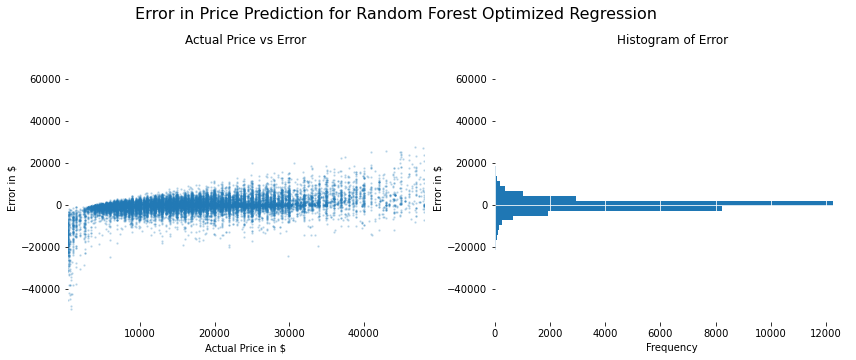

In [26]:
randf_opt2 =  RandomForestRegressor(**model_opt_rf.best_params_, n_estimators=150, max_depth=30)
y_predict_test_randf, c_randf = quick_run(randf_opt2, X_train_mm, y_train, X_test_mm, y_test,  name_g= 'Random Forest Optimized')

### Feature Importance Random Forest Regression

#### Create Feature Importance Tables

In [27]:
#Calculate feature importance train set given the first regression
feature_names = X_train.columns 
fimpotance_train = pd.DataFrame(randf_opt2.feature_importances_, columns=['Mean Feature Importance'], index=feature_names)
from sklearn.inspection import permutation_importance

In [28]:
from sklearn.inspection import permutation_importance
#Calculate feature importance for five splits using the train set
result_train = permutation_importance(randf_opt2, X_train_mm, y_train, n_repeats=5, n_jobs=-1, random_state=42)

#Create data frame of feature importances for the five folds given the train set
fimpotance_train2 = pd.DataFrame(result_train.importances.T, columns=feature_names)
fimpotance_train2

,odometer,age,MSRP,Avg_Gas_Price,Median Household Income,Avg_Mileage,smake,Lux,sLux,manufacturer_Acura,...,Category_Cleaned_Convertible,Category_Cleaned_Coupe,Category_Cleaned_Hatchback,Category_Cleaned_Pickup,Category_Cleaned_SUV,Category_Cleaned_Sedan,Category_Cleaned_Suv,Category_Cleaned_Unlisted,Category_Cleaned_Van/Minivan,Category_Cleaned_Wagon
0,0.369879,0.157032,0.010076,0.012879,0.010551,0.044308,0.368157,0.029896,0.000034,0.000096,...,0.001234,0.002249,0.001578,0.085757,0.004452,0.019383,0.002647,0.002843,0.003551,0.000079
1,0.366100,0.156801,0.009973,0.012883,0.010535,0.044123,0.372067,0.028330,0.000035,0.000101,...,0.001215,0.002086,0.001692,0.085268,0.004010,0.019513,0.002473,0.002910,0.003701,0.000083
2,0.370133,0.156846,0.009835,0.012975,0.010239,0.044066,0.367437,0.028049,0.000033,0.000096,...,0.001222,0.002159,0.001693,0.082923,0.004214,0.019909,0.002509,0.002826,0.003631,0.000077
3,0.369341,0.156025,0.009991,0.012796,0.010415,0.043860,0.369139,0.028632,0.000034,0.000099,...,0.001241,0.002155,0.001736,0.084603,0.004360,0.020438,0.002522,0.002703,0.003647,0.000078
4,0.368436,0.156826,0.009861,0.012849,0.010377,0.044307,0.365152,0.028022,0.000033,0.000096,...,0.001245,0.002243,0.001856,0.083728,0.004622,0.019471,0.002658,0.002768,0.003476,0.000084


In [29]:
#Calculate feature importance for five splits using the test set
from sklearn.inspection import permutation_importance
result_test = permutation_importance(randf_opt2, X_test_mm, y_test, n_repeats=5, random_state=42, n_jobs=-1)

#Create data frame of feature importances for the five folds given the test set
fimpotance_test2 = pd.DataFrame(result_test.importances.T, columns=feature_names)
fimpotance_test2

,odometer,age,MSRP,Avg_Gas_Price,Median Household Income,Avg_Mileage,smake,Lux,sLux,manufacturer_Acura,...,Category_Cleaned_Convertible,Category_Cleaned_Coupe,Category_Cleaned_Hatchback,Category_Cleaned_Pickup,Category_Cleaned_SUV,Category_Cleaned_Sedan,Category_Cleaned_Suv,Category_Cleaned_Unlisted,Category_Cleaned_Van/Minivan,Category_Cleaned_Wagon
0,0.306537,0.118455,0.008496,0.004425,0.002680,0.025575,0.323067,0.024374,0.000165,0.000061,...,0.001168,0.001297,0.001015,0.070818,0.002819,0.015629,0.001375,0.001812,0.002784,0.000062
1,0.308177,0.119518,0.008328,0.004733,0.003007,0.025438,0.333319,0.023965,0.000166,0.000061,...,0.001229,0.001267,0.001105,0.071361,0.003232,0.014624,0.001289,0.001821,0.002982,0.000050
2,0.311369,0.116850,0.008823,0.004506,0.002683,0.025217,0.327688,0.023279,0.000165,0.000064,...,0.001264,0.001222,0.001107,0.069589,0.003315,0.014177,0.001491,0.001582,0.002517,0.000056
3,0.309533,0.118048,0.008872,0.004435,0.002934,0.025599,0.329182,0.024457,0.000165,0.000057,...,0.001197,0.000925,0.001095,0.069117,0.003288,0.014514,0.001368,0.001511,0.002526,0.000041
4,0.308585,0.121907,0.008571,0.004442,0.003089,0.026563,0.334403,0.023389,0.000165,0.000062,...,0.001204,0.001108,0.001034,0.068744,0.002835,0.013408,0.001486,0.001612,0.002970,0.000043


#### Visualizing Feature Importance

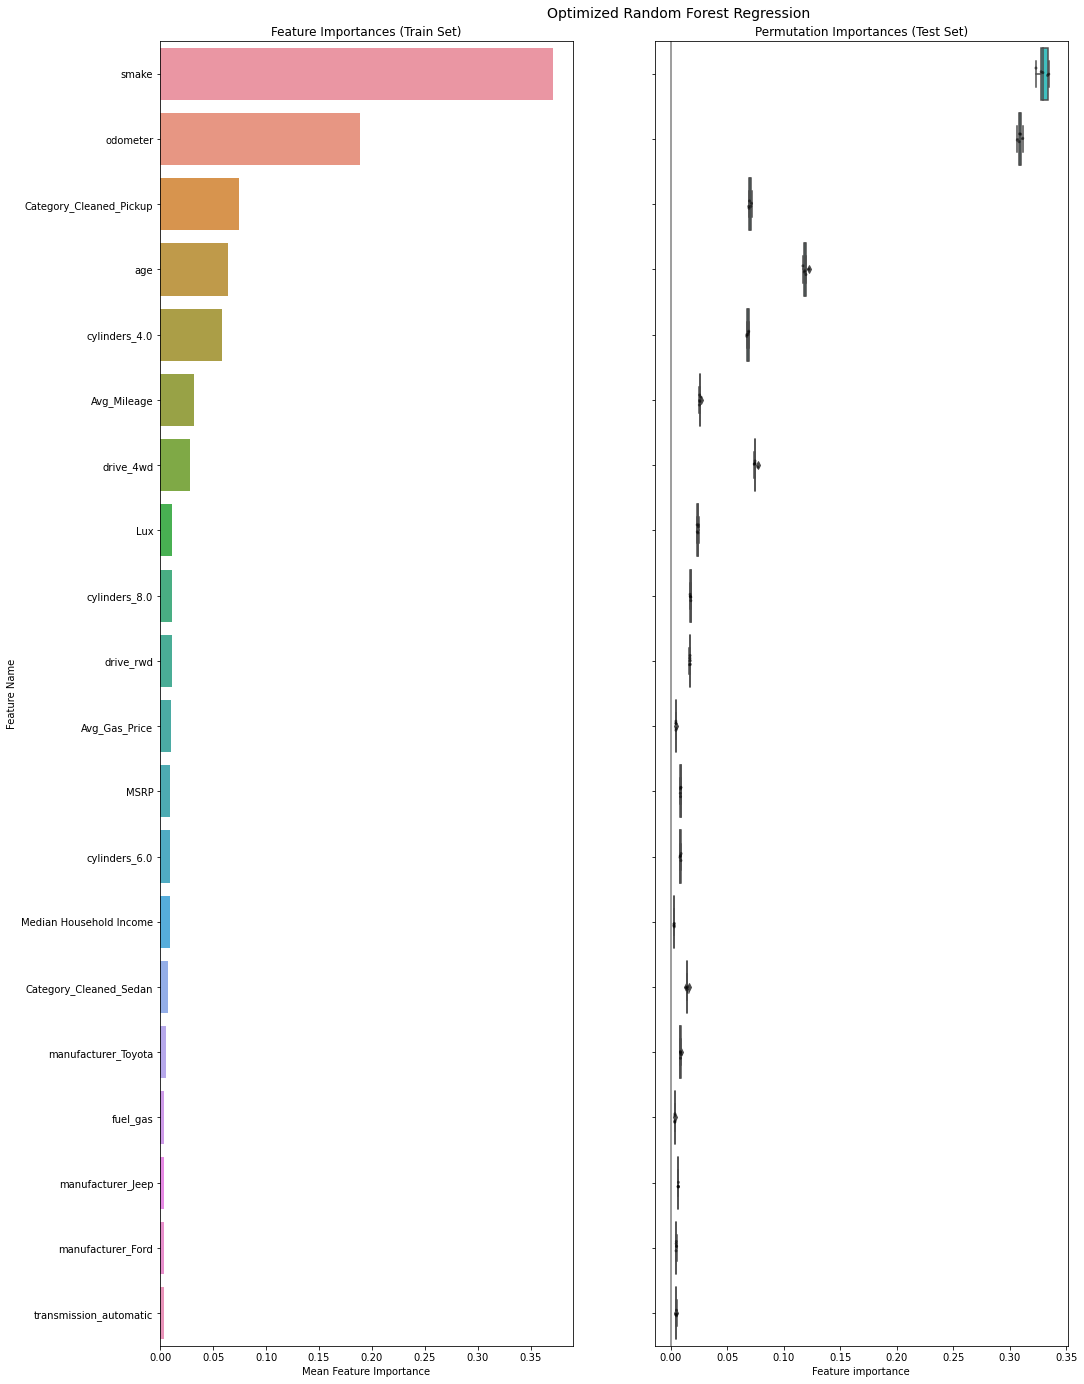

In [30]:
z_names_30 = fimpotance_train.sort_values(by= ['Mean Feature Importance'], ascending= False).head(20).index.tolist()
fimpotance_test2_f30 = fimpotance_test2[z_names_30]
z30 = fimpotance_train.sort_values(by= ['Mean Feature Importance'], ascending= False).head(20)
z30=z30.reset_index().rename(columns={"index": "Feature Name"})


fig, axs = plt.subplots(1, 2, figsize=(18, 24), sharey=True, sharex=True)
fig.suptitle('Optimized Random Forest Regression', fontsize=14, y=0.9, x= 0.6)
ax = plt.subplot(121)
sns.barplot(x='Mean Feature Importance',  y="Feature Name",  data=z30)
plt.title("Feature Importances (Train Set)")


plt.subplot(122)



#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=fimpotance_test2_f30, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=fimpotance_test2_f30, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (Test Set)")
plt.xlabel('Feature importance')
plt.subplots_adjust(left=.2)

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig("Feature Importance")


fimpotance_train2_f30 = fimpotance_train2[z_names_30]

fig, axs = plt.subplots(1, 2, figsize=(18, 24), sharey=True, sharex=True)
fig.suptitle('Optimized Random Forest Regression', fontsize=14, y=0.9, x= 0.6)
ax = plt.subplot(121)
sns.barplot(x='Mean Feature Importance',  y="Feature Name",  data=z30)
plt.title("Feature Importances (Train Set)")


plt.subplot(122)



#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=fimpotance_train2_f30, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=fimpotance_train2_f30, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (Train Set)")
plt.xlabel('Feature importance')
plt.subplots_adjust(left=.2)

for ax in fig.get_axes():
    ax.label_outer()
#fig.title('Ridge model no PCA Coefficents')

### Final Test Data (Validate)

#### Acquiring Test Data

In [40]:
# Create the list of file names: filenames
file ='auto_data_cleaned.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
df_fin = pd.read_csv(file_name_path)
df_fin = df_fin.reset_index()



df_fin.info()
df_fin.smake.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114811 entries, 0 to 114810
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    114811 non-null  int64  
 1   price                    114811 non-null  int64  
 2   manufacturer             114811 non-null  object 
 3   condition                114811 non-null  object 
 4   cylinders                114811 non-null  float64
 5   fuel                     114811 non-null  object 
 6   odometer                 114811 non-null  float64
 7   transmission             114811 non-null  object 
 8   drive                    114811 non-null  object 
 9   size                     114811 non-null  object 
 10  paint_color              114811 non-null  object 
 11  state                    114811 non-null  object 
 12  age                      114811 non-null  float64
 13  MSRP                     114811 non-null  float64
 14  Avg_

0    97251
1     8051
2     7722
3     1158
4      629
Name: smake, dtype: int64

#### Pre Processing

In [41]:
#Get dummies
df_fin['cylinders'] = df_fin['cylinders'].astype('category')


kw= ['Mercedes-Benz', 'Bmw', 'Audi', 'Land-Rover', 'Lexus', 'Acura', 'Jaguar']
qw= ['Alfa-Romeo', 'Tesla', 'Porsche']
df_fin['Lux'] = df_fin['manufacturer'].apply(lambda x: any([k in x for k in kw])).astype(int)
df_fin['sLux'] = df_fin['manufacturer'].apply(lambda x: any([q in x for q in qw])).astype(int)
df_fin= pd.get_dummies(df_fin) 

#Correlation is not a big deal for random Forest Regression so we keep them in

#seperate X and y from each other
y = df_fin['price']
X =df_fin.drop(columns=['price', 'index'], axis=1)


# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.25, random_state=42)


# Create val and train sets
X_train3, X_test2, y_train3, y_test2 = train_test_split(X_train, y_train, test_size = 3/11, random_state=42)

#Combine Train and Validation data together to get larger data set
X_train2 = X_train3.append(X_test, ignore_index=True)
y_train2 = y_train3.append(y_test, ignore_index=True)

#standardize numeric variables
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #create scaler

#Scale numeric data
X_train2_mm = scaler.fit_transform(X_train2)
X_test2_mm = scaler.transform(X_test2)
X_test2_mm.shape

(23484, 149)

#### Prediction

In [42]:
#Use previous Hypertuned Spec
#randf_opt3 = RandomForestRegressor(**model_opt_rf.best_params)
randf_opt3 =  RandomForestRegressor(**model_opt_rf.best_params_, n_estimators=150, max_depth=30)


Cross Validated Scores for regression equation: Random Forest All Data 
Median Absolute Error: 
Mean train score: $1143 
Mean test score: $1630 
Standard Deviation test score: $26 

MPE: 
Mean train score: 0.00070 
Mean test score: -0.00224 
Standard Deviation test score: 0.00269 



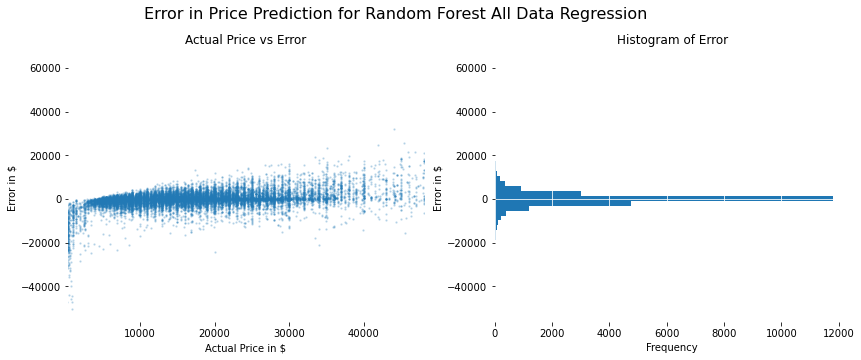

In [43]:


y_predict_test_randf, c_randf = quick_run(randf_opt3, X_train2_mm, y_train2, X_test2_mm, y_test2,  name_g= 'Random Forest All Data')


<AxesSubplot:ylabel='Count'>

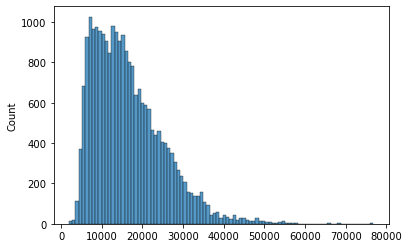

In [55]:
sns.histplot(y_predict_test_randf)

### Is Our Model Good ?

Is at least 95% of the data withing the prediction +/- 5000

### Prediction


list_1 = X_test2.columns.to_list()
list_2 = X_tesla.columns.to_list()
#main_list = np.setdiff1d(list_1,list_2)
#main_list = np.setdiff1d(list_2,list_1)
main_list

<AxesSubplot:xlabel='error', ylabel='Count'>

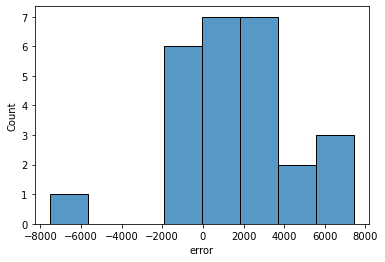

In [180]:
# Data From Craiglist January 2021
file ='ravi.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
df_2021 = pd.read_csv(file_name_path)
df_2021 = df_2021.reset_index()


#seperate X and y from each other
y_2021_actual = df_tesla['price']
X_2021 =df_2021.drop(columns=['price', 'index'], axis=1)
X_2021_mm = scaler.fit_transform(X_2021)

#Predict Tesla
y_2021_predict= randf_opt3.predict(X_2021_mm)
cx = pd.concat([y_tesla_actual, pd.Series(y_tesla_predict, name='prediction')], axis=1 )
cx['error']= cx['prediction']-cx['price']

sns.histplot(data=cx, x="error")


<AxesSubplot:xlabel='error', ylabel='Count'>

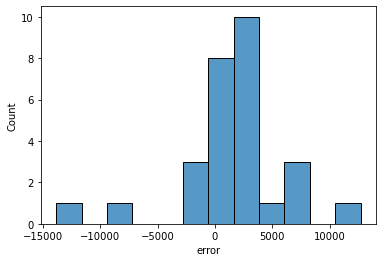

In [185]:
# Data From Tesla
file ='ravi_plus_tesla.csv'
sub_file = 'data'
file_name_path = os.path.join(basepath, sub_file, file)
df_tesla = pd.read_csv(file_name_path)
df_tesla = df_tesla.reset_index()


#seperate X and y from each other
y_tesla_actual = df_tesla['price']
X_tesla =df_tesla.drop(columns=['price', 'index'], axis=1)
X_tesla_mm = scaler.fit_transform(X_tesla)

#Predict Tesla
y_tesla_predict= randf_opt3.predict(X_tesla_mm)
cx = pd.concat([y_tesla_actual, pd.Series(y_tesla_predict, name='prediction')], axis=1 )
cx['error']= cx['prediction']-cx['price']

sns.histplot(data=cx, x="error")

In [186]:
cx

,price,prediction,error
0,4950,6805.220,1855.220
1,6900,10488.893,3588.893
2,5250,7522.212,2272.212
3,5500,9308.819,3808.819
4,9940,11581.396,1641.396
5,6950,10089.991,3139.991
6,11000,10822.364,-177.636
7,5799,13246.094,7447.094
8,13300,14819.538,1519.538
9,10300,12083.433,1783.433


In [166]:
feature_names= X_tesla.columns
fx = pd.DataFrame(randf_opt3.feature_importances_, columns=['Mean Feature Importance'], index=feature_names)
pd.options.display.float_format = '{:.3f}'.format
fx.sort_values('Mean Feature Importance', ascending= False).head()

,Mean Feature Importance
smake,0.356
odometer,0.184
drive_fwd,0.087
age,0.065
Category_Cleaned_Pickup,0.060


In [172]:
should_buy = y_tesla_predict[y_tesla_predict>30000]
np.count_nonzero(should_buy)

4

### Next Steps
    * Redo this study with More MSRP data available
    * Two Step Algorithm- A lot of the algorithms likely to underestimate vehicles priced at over 35K. It might be good to first come up with a classifier that seperates that out and then see what model works